# 0.0. IMPORTS

In [82]:
import math
import random
import pickle
import warnings
import numpy as np
import pandas as pd
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                import stats
from boruta               import BorutaPy
from tabulate             import tabulate
from matplotlib           import pyplot as plt
from IPython.display      import Image
from IPython.core.display import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
def ml_error(model_name, y, yhat): # model_name = nome do modelo, y = valores reais, yhat = valores preditos (estimativas)
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# Função de Cramer V
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
# low_memory=False: Fala pra função read_csv ler todo o arquivo de uma vez só para a memória. Se for true vai ler de pedaço em pedaço.
df_sales_raw = pd.read_csv('/Users/deboragoncalves/Documents/repos/Data_science_em_producao/Projeto_rossmann_store_sales/rossmann-store-sales/train.csv', low_memory = False)
df_store_raw = pd.read_csv('/Users/deboragoncalves/Documents/repos/Data_science_em_producao/Projeto_rossmann_store_sales/rossmann-store-sales/store.csv', low_memory = False)

# merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

# faz o mapeamento da função snakecase em todas as palavras da lista cols_old, e o retorno seja uma lista para 
# fazer o rename da coluna e ai guardamos a nova lista em uma variavel nova chamada cols_news
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
# competition_distance: se NA é porque não tem um competidor próximo da loja, ou é uma loja muito distante para ser um competidor.
# Se colocarmos uma distancia muito maior que a distância máxima que tem nos dados, é a mesma coisa que dizer que não existe um competidor próximo.
# regra: inserimos um valor baseado no max 'competition_distance' em todos NAs
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month: mês aproximado que o competidor mais próximo foi aberto
# Se NA é porque não tem um competidor próximo da loja, ou a loja tem um competidor próximo mas não sabe a data que a loja mais próxima 
# foi aberta, uma porque a loja competidora abriu muito antes da loja ser aberta, ou porque abriu depois e alguém esqueceu de anotar.
# regra: se NA pegar o mês da coluna date. Porque podemos avaliar o motivo das vendas cairem quando surge uma nova loja competindo e 
# aumentando depois de um período porque os clientes se acostumam com as duas lojas próximas e voltam a comprar em ambas.
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                                    else x['competition_open_since_month'], axis=1 )

# competition_open_since_year: ano aproximado que o competidor mais próximo foi aberto
# Se NA é porque não tem um competidor próximo da loja, ou a loja tem um competidor próximo mas não sabe a data que a loja mais próxima 
# foi aberta, uma porque a loja competidora abriu muito antes da loja ser aberta, ou porque abriu depois e alguém esqueceu de anotar.
# regra: se NA pegar o mês da coluna date. Porque podemos avaliar o motivo das vendas cairem quando surge uma nova loja competindo e 
# aumentando depois de um período porque os clientes se acostumam com as duas lojas próximas e voltam a comprar em ambas.
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) 
                                                    else x['competition_open_since_year'], axis=1 )

# promo2_since_week: descreve a semana do calendário de quando a loja começou a participar da promo2, promo2 é a continuação
# de uma promoção para algumas lojas
# Se NA a loja não aceitou participar da promoção. 
# regra: Vamos substituir NA pela data da coluna date.
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# promo2_since_year: descreve o ano de quando a loja começou a participar da promo2, promo2 é a continuação de uma promoção para algumas lojass
# Se NA a loja não aceitou participar da promoção.
# regra: Vamos substituir NA pelo ano data da coluna date.
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval: quais são os intervalos que a promo2 iniciou, nomeando os meses da promoção.
# regra: Fazer um split dessa coluna e criar uma lista, se a data estiver dentro da lista, criar coluna que a promo2 foi ativa.
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# se NA substituir por 0
df1['promo_interval'].fillna(0, inplace=True )

# pega a date e tranforma a data que é ano, mes e dia, tranforma em data e depois em mês e aplica o month_map, para que os
# numeros sejam substituidos pelas letras
df1['month_map'] = df1['date'].dt.month.map( month_map )

# pegar o promo_interval e fazer um split baseado na virgula, para poder quebrar o array que está separado por virgula em uma lista
# e ai vai ver se o month_map está dentro dessa lista, se sim, retorna 1, senão, retorna 0.
# Se promo_interval igual a 0, retorna zero, senão 1
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                             if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

## 1.6. Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 1.7.1. Numerical Attributes

In [13]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

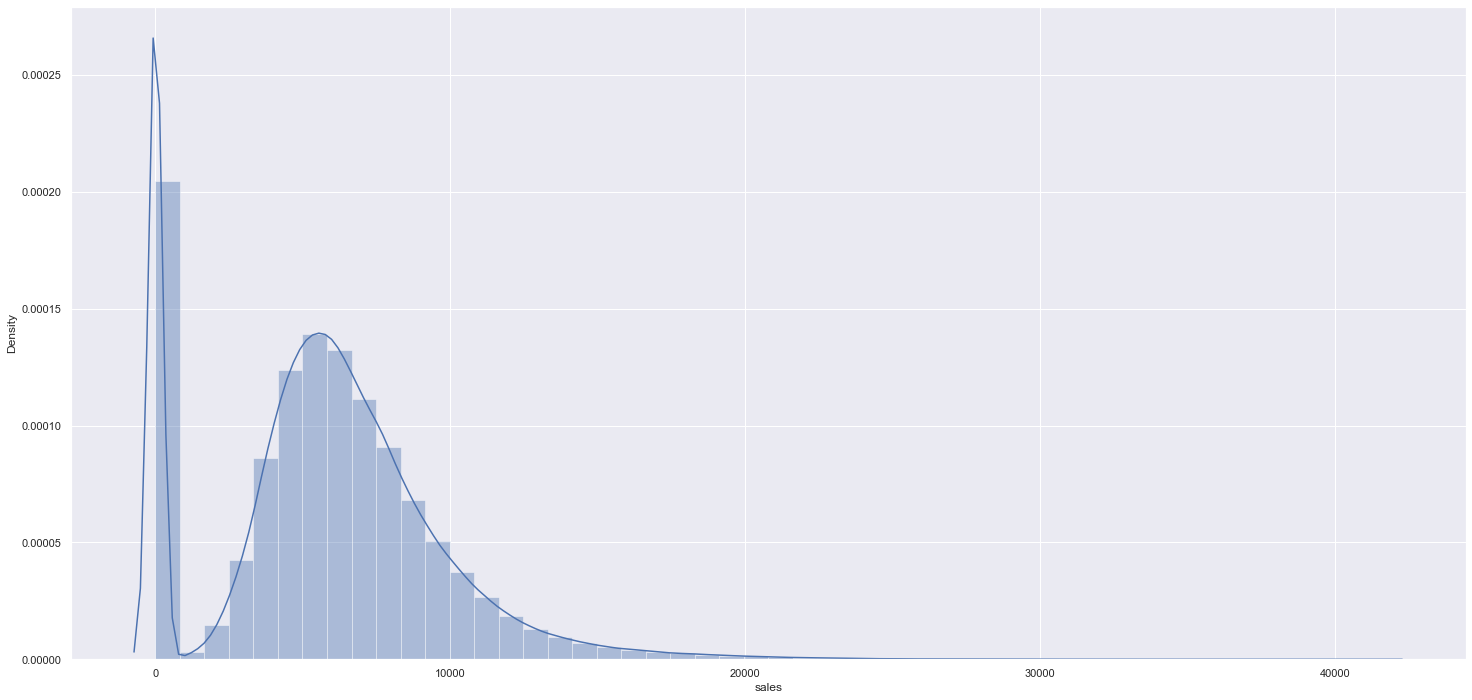

In [14]:
sns.distplot(df1['sales'])

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

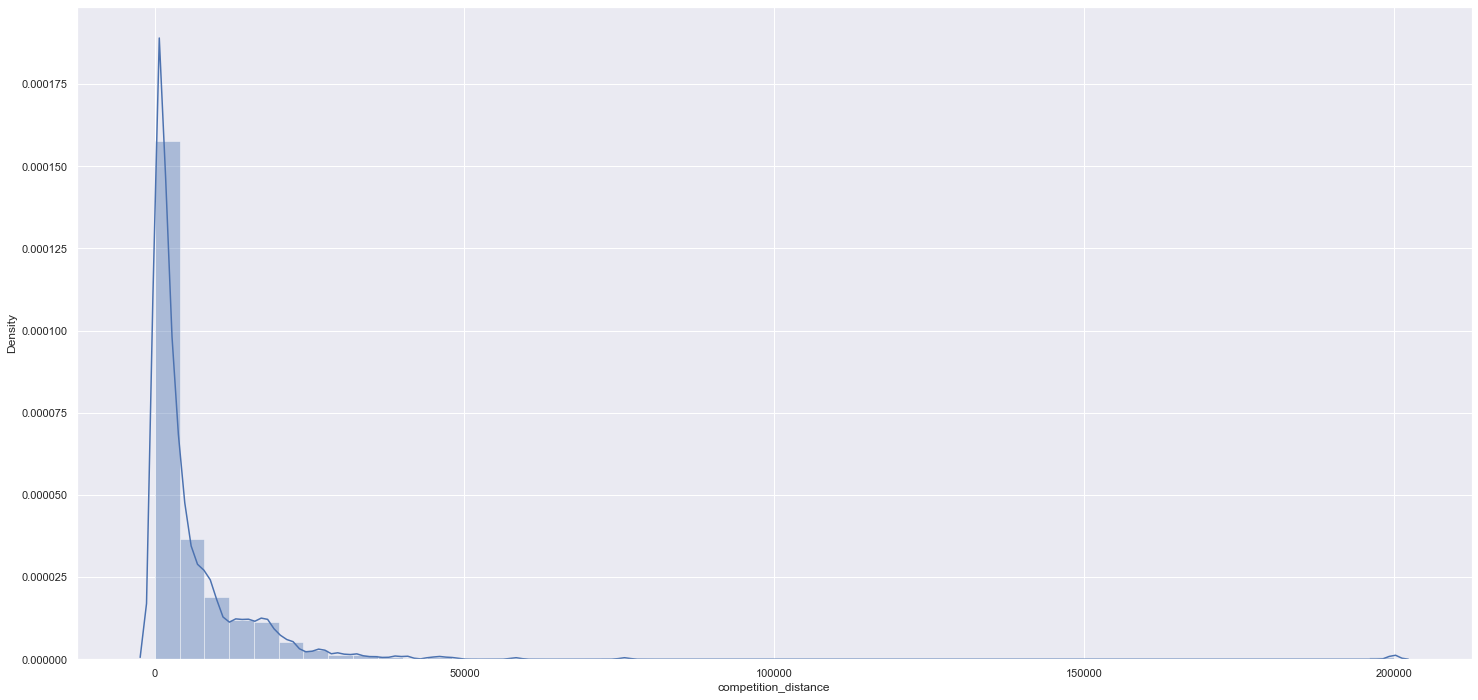

In [15]:
sns.distplot(df1['competition_distance'])

## 1.7.2. Categorical Attributes

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

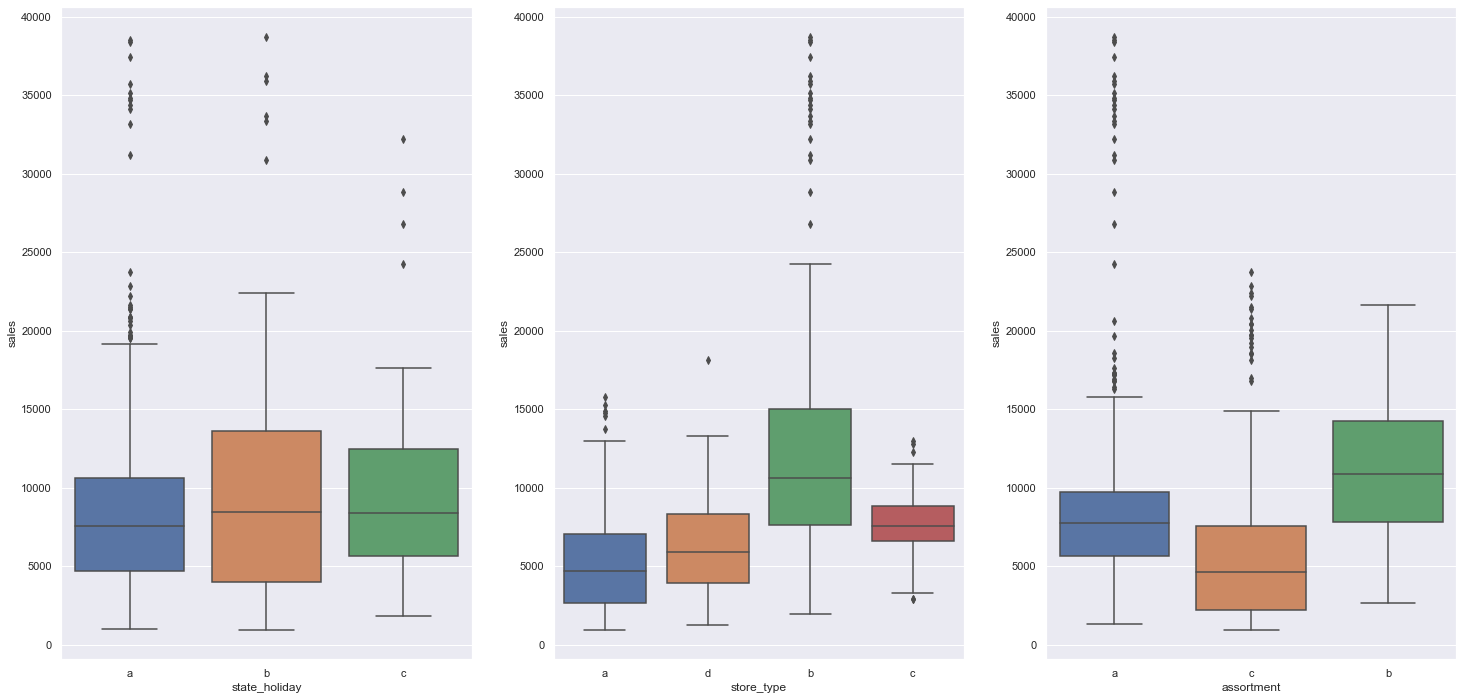

In [17]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# tudo que estiver fora do boxplot são outliers, que são considerados 3 vezes o desvio padrão.

# o feriado B tem uma mediana maior que a do A, mas muito parecida com a C, só que tem um equilibrio entre o número de valores que tem
# entre o quartil 50 até o 75 e do quartil 25 até o 50. No feriado C tem um volume maior de vendas do quartil 50 até o 75. 
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

# O tipo de loja B tem muito mais outiliers que as outras e a mediana de vendas da loja B é muito maior que as outras também.
# E em segundo lugar vem o tipo de loja C, a mediana é maior que a da A e D, porém os dados estão um pouco volumosos em torno da mediana,
# então quer dizer que tem uma concentração maior em torno da mediana. As lojas A e D, tem uma dispersão em torno da mediana mais similar
# entre si, mas uma mediana é diferente da outra.
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

# Tem mix de produtos muito mais distribuidos no assortment B do que no assortment A, porém no A tem muito mais outliers.
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

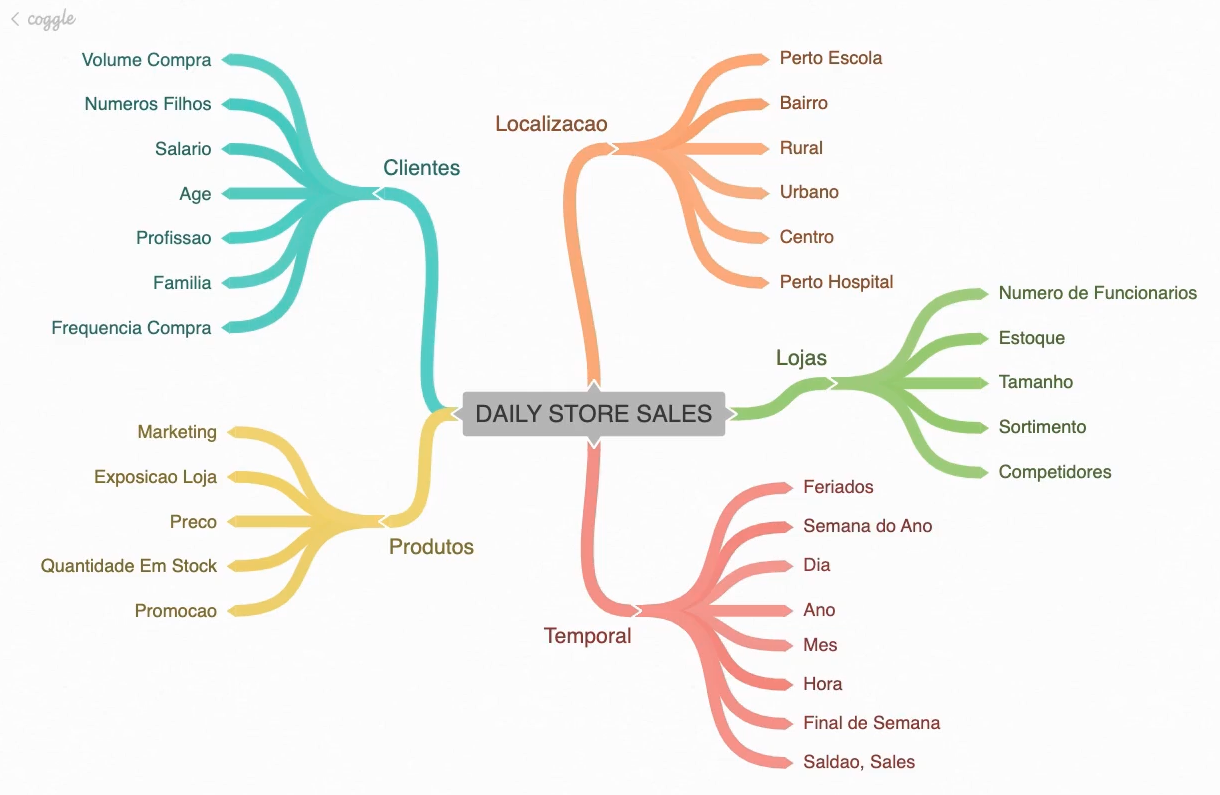

In [19]:
Image('/Users/deboragoncalves/Documents/repos/Data_science_em_producao/Projeto_rossmann_store_sales/images/MindMapHypothesis.png')

### 2.1. Criação das Hipóteses

#### 2.1.1. Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

#### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competion since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply( lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                  if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [21]:
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
966219,300,5,2013-02-15,5314,689,1,0,regular_day,0,a,extended,120.0,4,2009,1,1,2012,"Jan,Apr,Jul,Oct",Feb,0,2013,2,15,7,2013-06,2009-04-01,47,2011-12-26,59
701678,14,4,2013-10-10,5971,689,1,1,regular_day,0,a,basic,1300.0,3,2014,1,40,2011,"Jan,Apr,Jul,Oct",Oct,1,2013,10,10,41,2013-40,2014-03-01,-5,2011-09-26,106
430555,951,3,2014-06-11,6185,632,1,0,regular_day,0,d,extended,710.0,6,2014,1,40,2011,"Jan,Apr,Jul,Oct",Jun,0,2014,6,11,24,2014-23,2014-06-01,0,2011-09-26,141
203605,676,5,2015-01-30,9556,1951,1,1,regular_day,0,b,extra,1410.0,9,2008,0,5,2015,0,Jan,0,2015,1,30,5,2015-04,2008-09-01,78,2015-01-26,0
139149,890,7,2015-03-29,0,0,0,0,regular_day,0,a,basic,4450.0,3,2015,1,14,2011,"Jan,Apr,Jul,Oct",Mar,0,2015,3,29,13,2015-12,2015-03-01,0,2011-03-28,208


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [22]:
df3 = df2.copy()

In [23]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [24]:
# Filtrar linhas de lojas abertas somente e sales maior que 0.
df3 = df3[(df3['open'] != 0) & (df2['sales'] > 0)]

## 3.2. Seleção das Colunas

In [25]:
# Dropar colunas costumers, open (uma vez que filtramos todas as linhas onde o open é diferente de 0, todas as linhas que 
# sobraram são open igual a 1, então a coluna open é só 1, e não ter variabilidade de nada). 
# As colunas, promo_interval, derivamos variaveis (is_promo).
# E a coluna month_map que usamos como auxiliar. 
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [26]:
df4 = df3.copy()

## 4.1. Análise Univariada
Objetivo: Olhar unicamente para todas as variáveis.

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

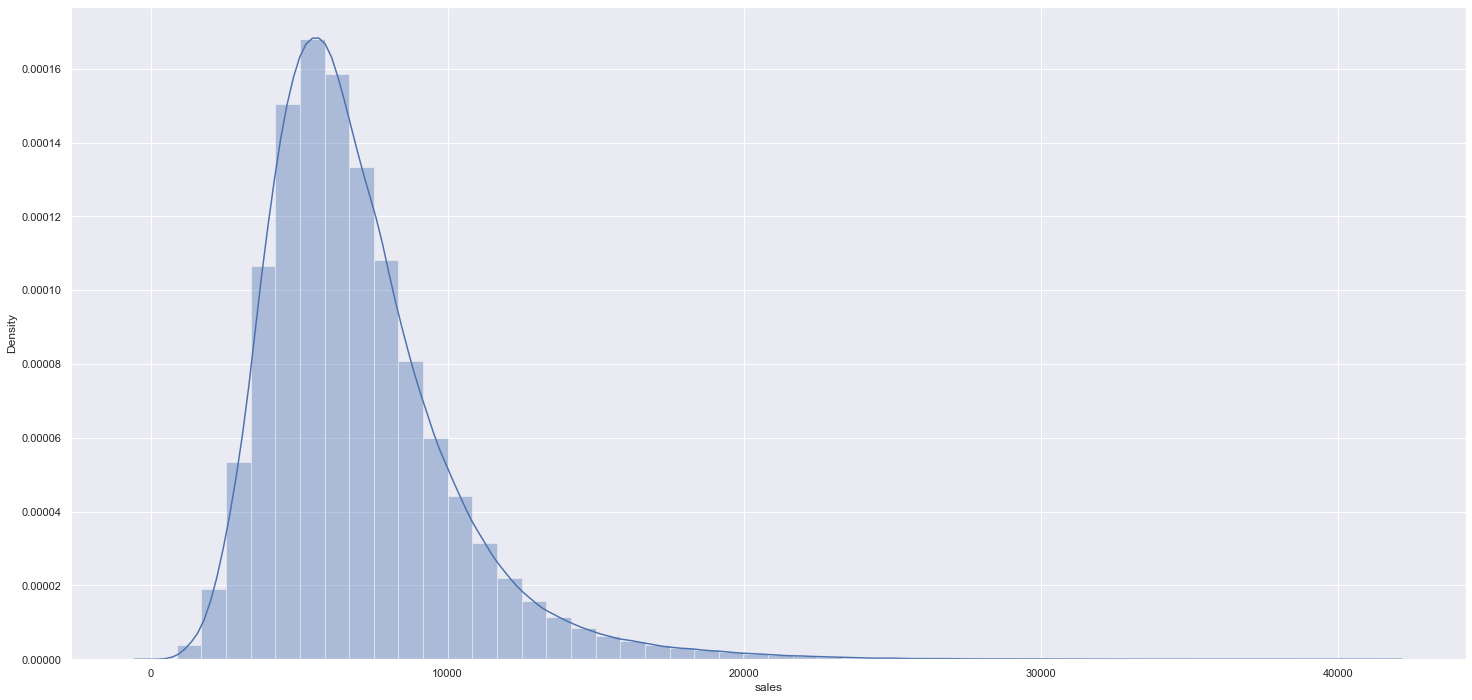

In [27]:
sns.distplot(df4['sales'])
# Tem kurtosi, tem uma skill mais para a esquerda, então é positiva, mas não está centrada.
# Quanto mais normal for a variável resposta, melhor o algoritmo vai performar.

### 4.1.2. Numerical Variable

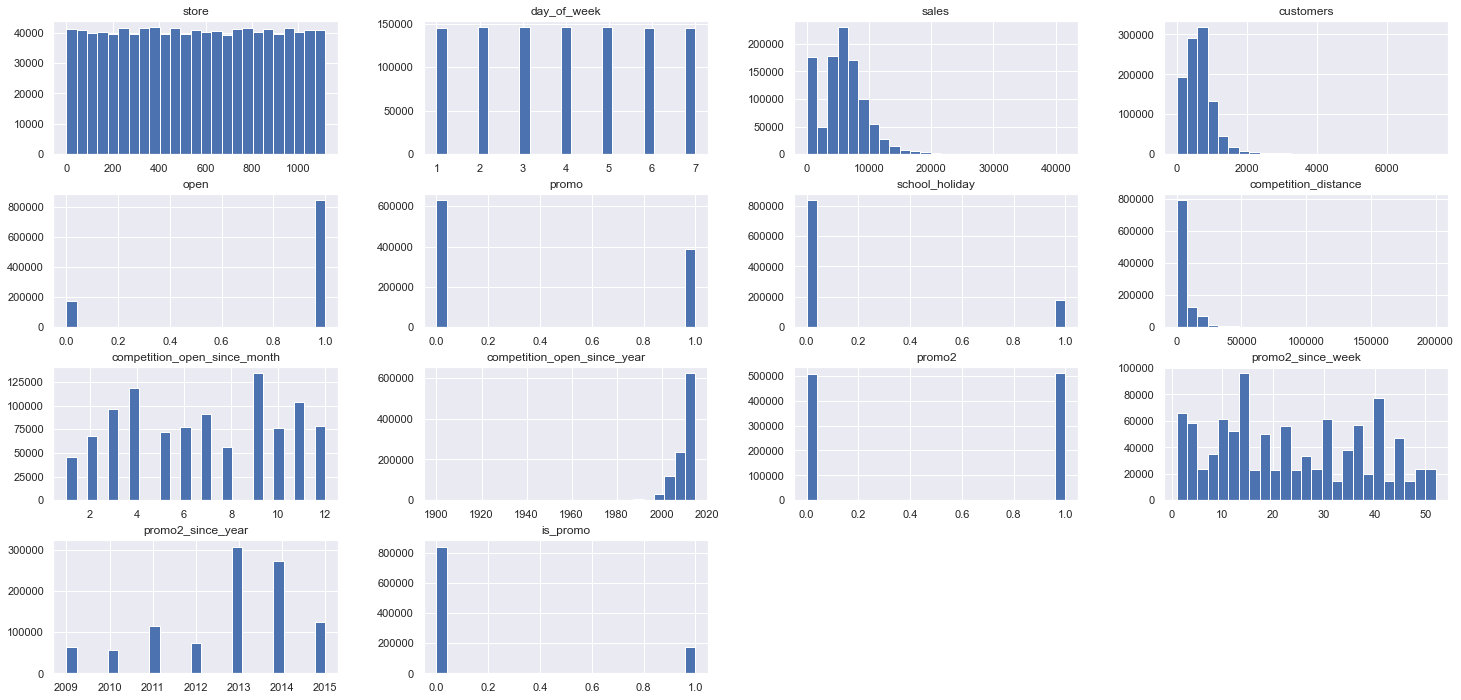

In [28]:
num_attributes.hist(bins=25);

Insights:
- competition_distance: concentração maior na distância dos competidores menor, todos os competidores estão muito próximos.
- competition_open_since_month (distância que o competidor abriu em meses): tem um pico nos competidores que abriram 4 meses atrás. Depois cai um pouco e sobe de novo no 7º mês.
- day_of_week: não importa o dia da semana, vende igual em todos eles. Não tem um comportamento, sozinha se não for comparada com nada, não tem informação relevante para o aprendizado do modelo.
- is_promo: tem muito mais vendas quando não tem promoção. Quando tem promoção tem menos linhas de vendas.
- promo2_since_year: número de vendas vai aumentando, em 2013 tem um pico. 2014 caiu um pouco e 2015 volta mais ou menos para as vendas antes de 2013.
- customers: temos mais vendas quando customers estão próximos a 300 mil.

### 4.1.3. Categorical Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

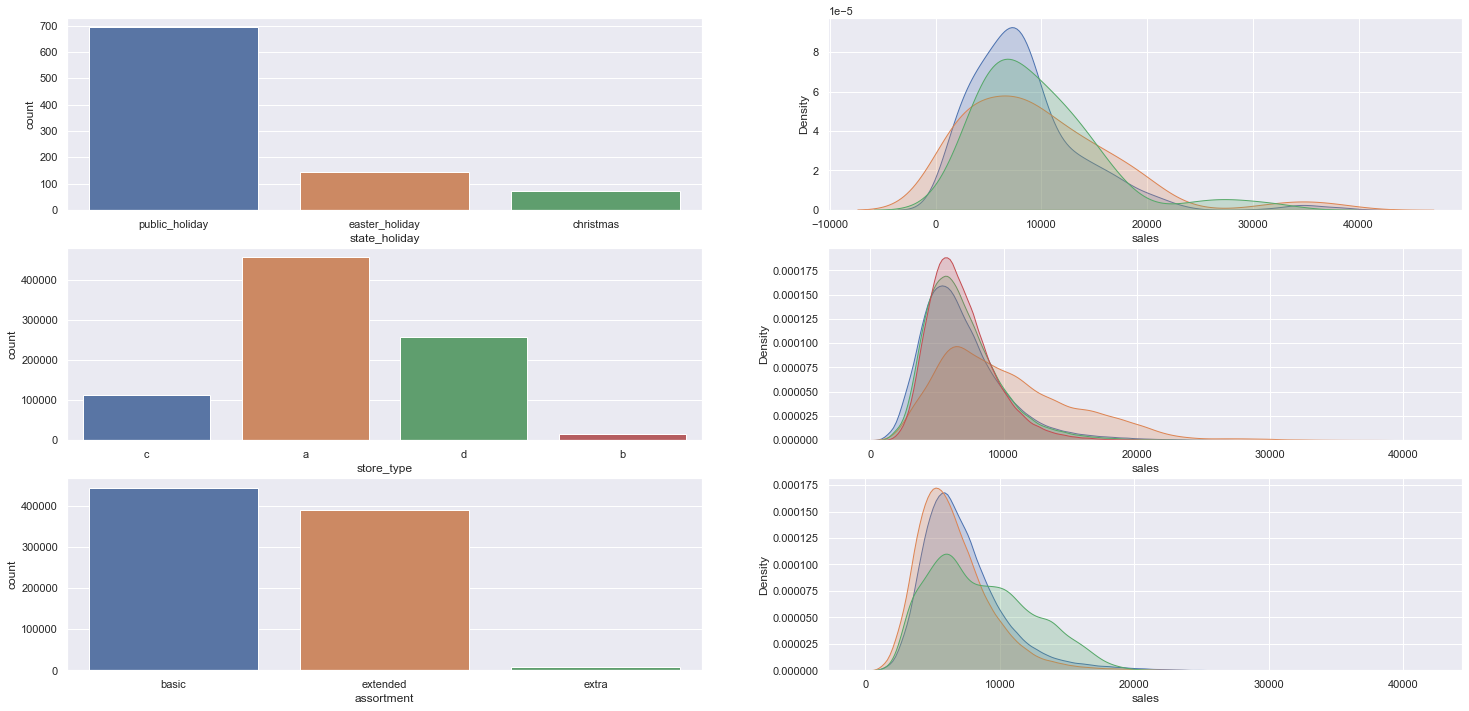

In [29]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True )

Insights:
- Public_holiday tem um volume muito maior de vendas, então ele tem um pico muito maior. Christmas tem um volume menor mas tem um pico muito maior que o easter_holiday.
- O tipo de loja A tem um volume de vendas muito maior, mas não tem um pico tão grande. Enquanto lojas do tipo B tem uma alta concentração.
- Tipos de assortment que vendem mais é o básico, depois o extended e o extra vende pouco. Já o extra tem um pico menor mas tem uma distribuição maior. Então temos mais lojas com diferentes tipos de extras, tem lojas que vendem mais com o assortment extra, lojas que vendem menos com assortment extra.

## 4.2. Análise Bivariada
Objetivo: Encontrar o impacto de uma variável em relação a variável resposta.

In [30]:
# Média de vendas total
df4['sales'].mean()

6955.959133664481

### H1. Lojas com maior sortimentos deveriam vender mais.
**VERDADEIRA**: Na média, lojas com MAIOR SORTIMENTO vendem MAIS.

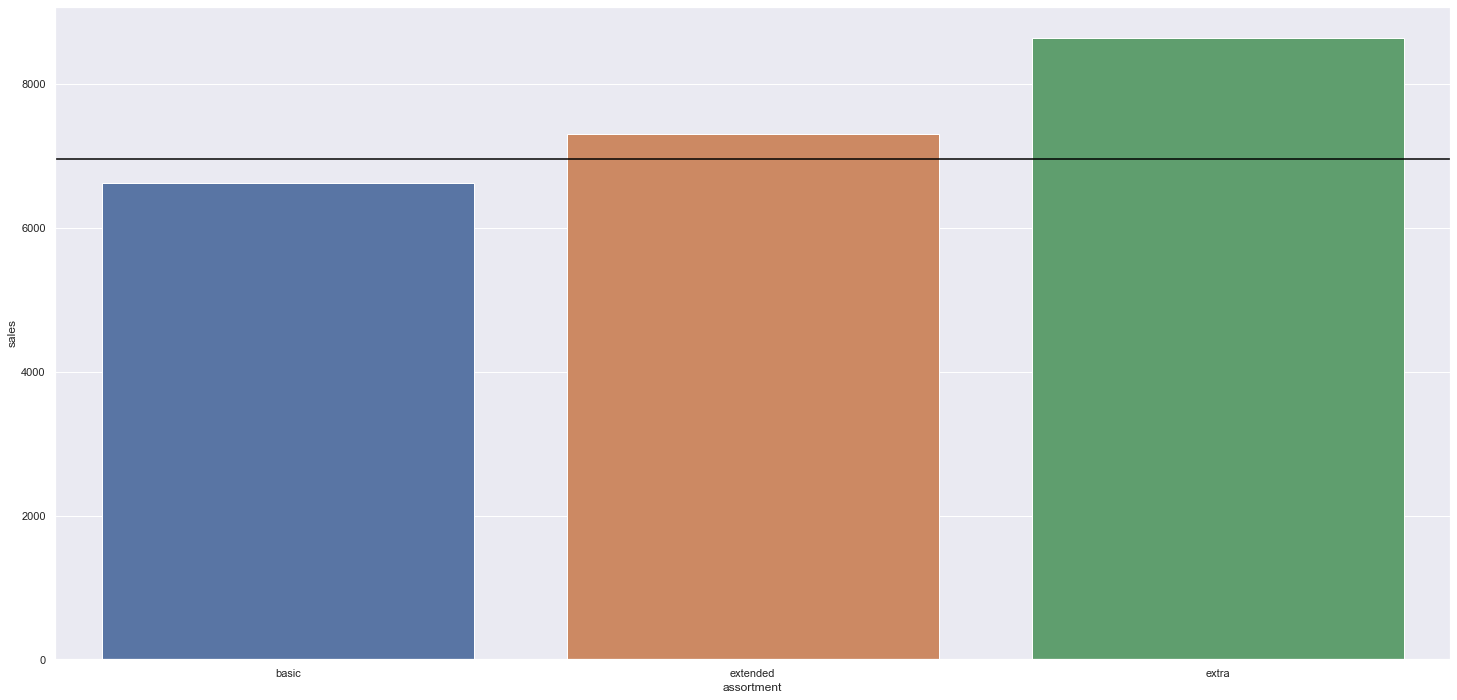

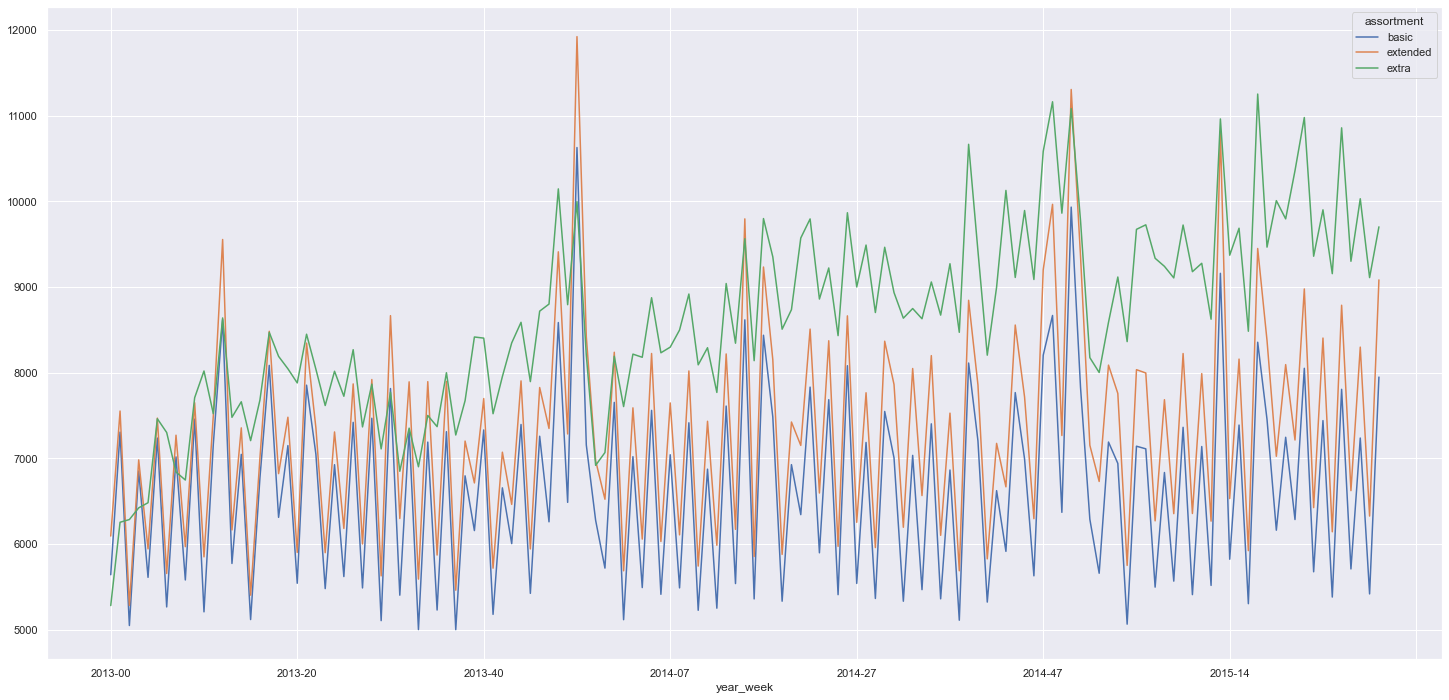

In [31]:
# Estratégia: pegar a média de vendas por assortment.

# Gráfico de média de vendas por assortment.
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);
plt.axhline(6955, 0, 1, color='black');

# Gráfico de linhas por assortment para comparar semana a semana.
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

# aux3 = aux2[aux2['assortment'] == 'extra']
# aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA**: Lojas com competidores mais próximos entre 0 a 2000 metros, vendem acima da média de vendas que é 6955.

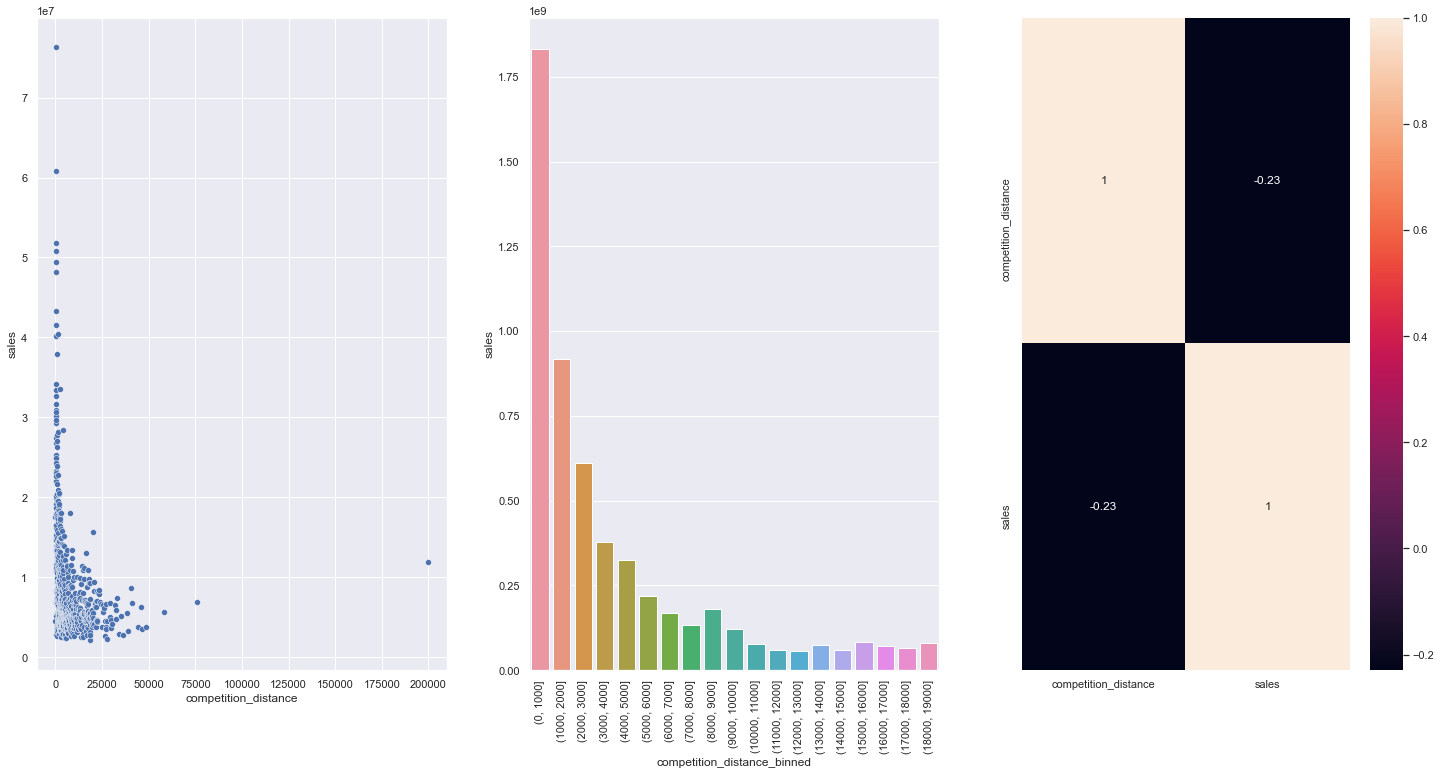

In [32]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Gráfico de dispersão com total de vendas por grupos de distância de lojas
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000, 1000))
# Total de vendas por grupos de distância de lojas
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

# Gráfico que mede a força da correlação entre a competition_distance e as vendas
# -0.23 significa que quanto mais distante o meu conconcorrente está, menor a venda.
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

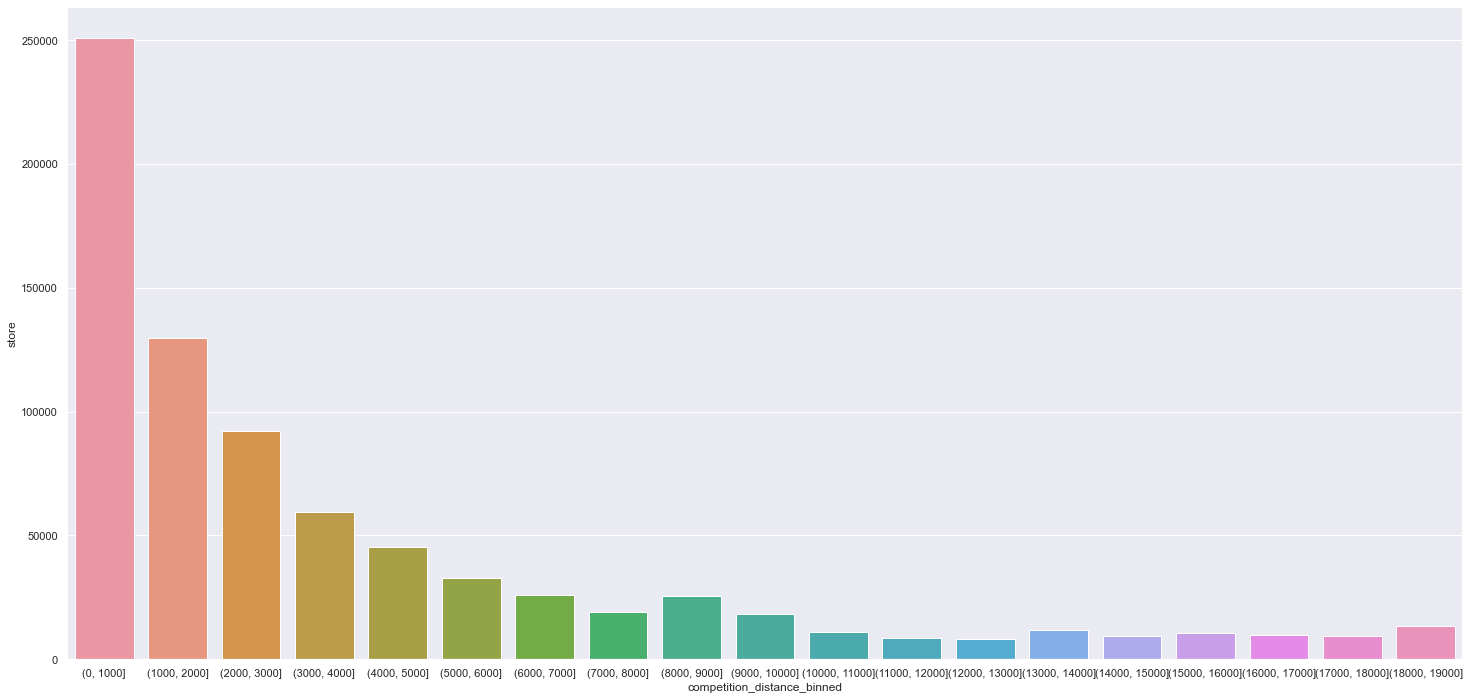

In [33]:
# Total de lojas por grupos de distância de lojas
aux3 = df4[['competition_distance', 'store']].groupby('competition_distance').count().reset_index()

aux3['competition_distance_binned'] = pd.cut(aux3['competition_distance'], bins=bins)
aux4 = aux3[['competition_distance_binned', 'store']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y='store', data=aux4);

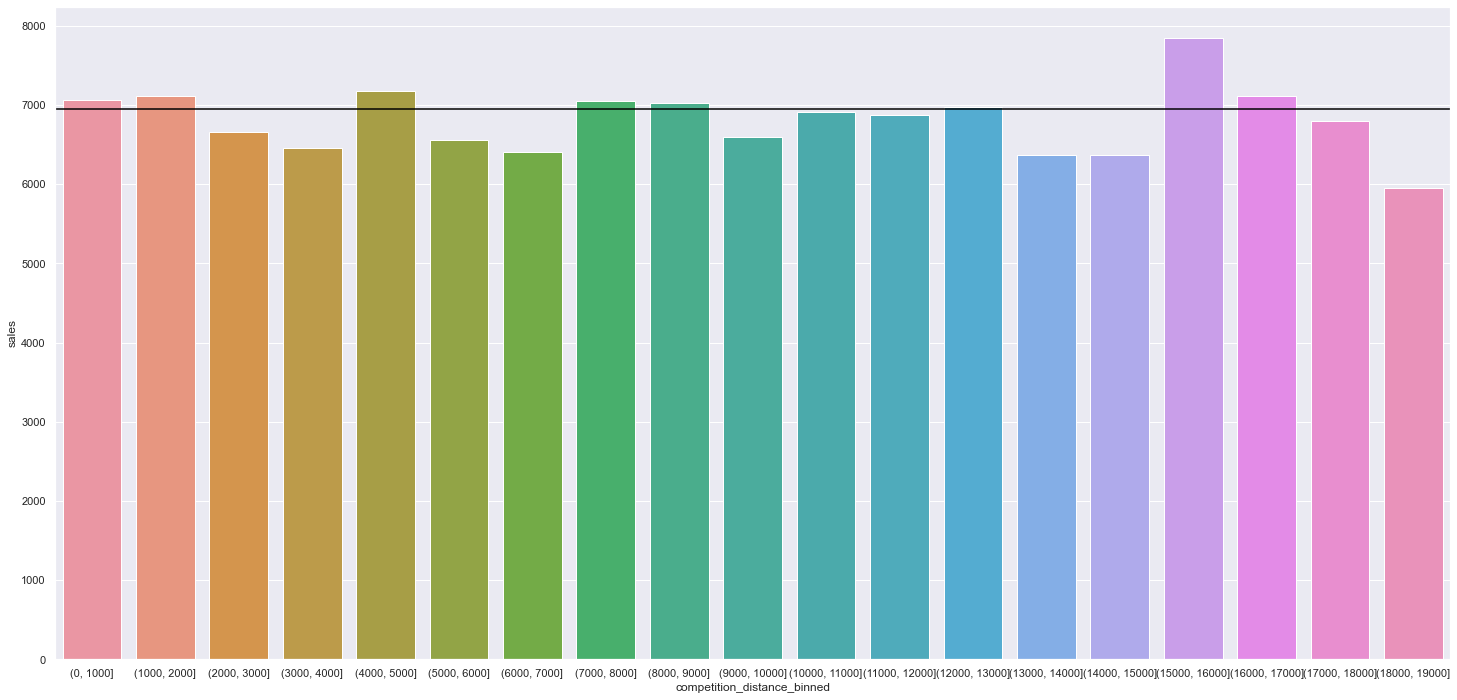

In [34]:
# Média de vendas por grupo de distância de lojas
df_mean = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

df_mean['competition_distance_binned'] = pd.cut(df_mean['competition_distance'], bins=bins)
aux5 = df_mean[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data=aux5);
plt.axhline(6955, 0, 1, color='black');

### H3. Lojas com competidores à mais tempo deveriam vender mais.
**FALSA**: Lojas com competidores à mais tempo vendem menos que a média de vendas que é de 6955.

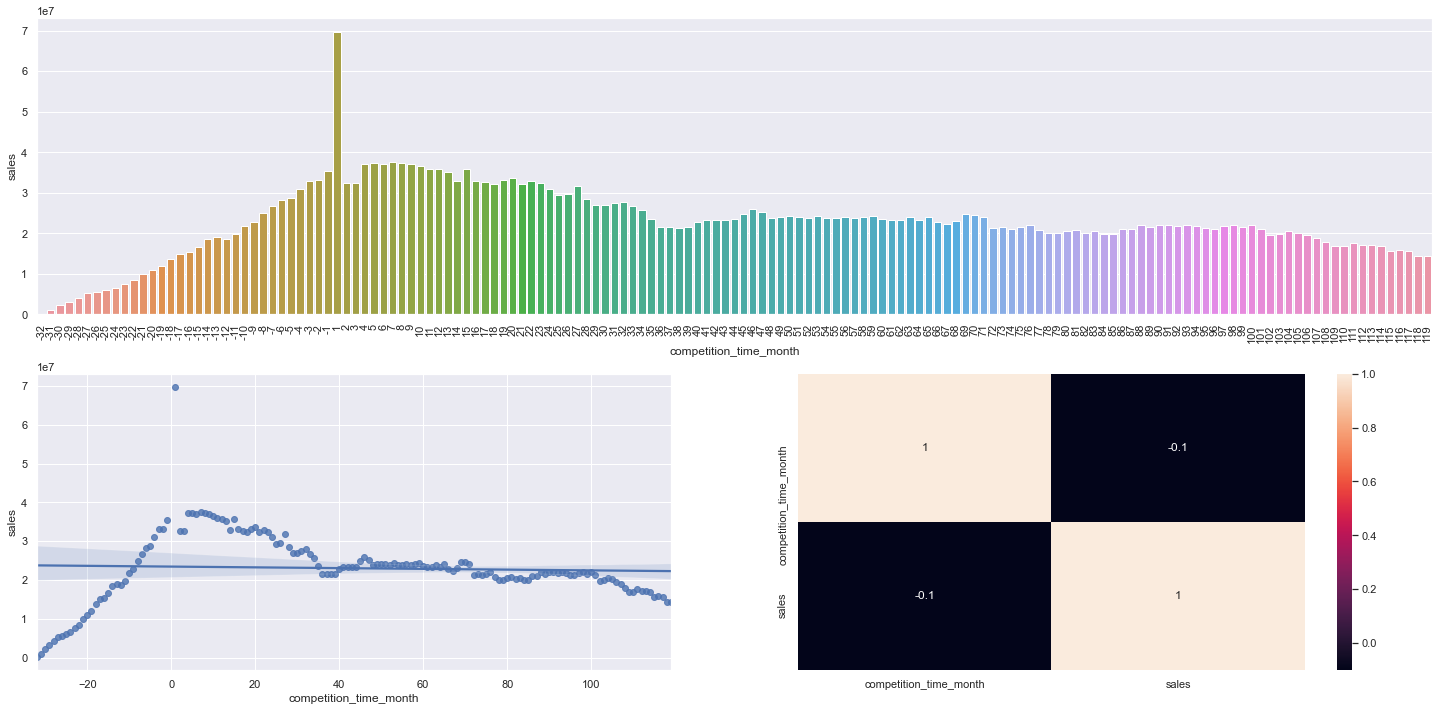

In [35]:
# Valores negativos são referentes a vendas que aconteceram antes da competição entrar em vigor.
# Valores positivos são referentes a vendas que aconteceram depois da competição entrar em vigor.

# Total de vendas por meses de competição
plt.subplot(2,1,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)] # 120 primeiros meses de competição e não competiram no mesmo mês da venda
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

# Gráfico que mede comportamento e tendência
plt.subplot(2,2,3)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

# Gráfico que mede a força da correlação entre a competition_time_month e as vendas
# O tempo que o competidor começou em meses em relação a variável resposta é -0.1. 
plt.subplot(2,2,4)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

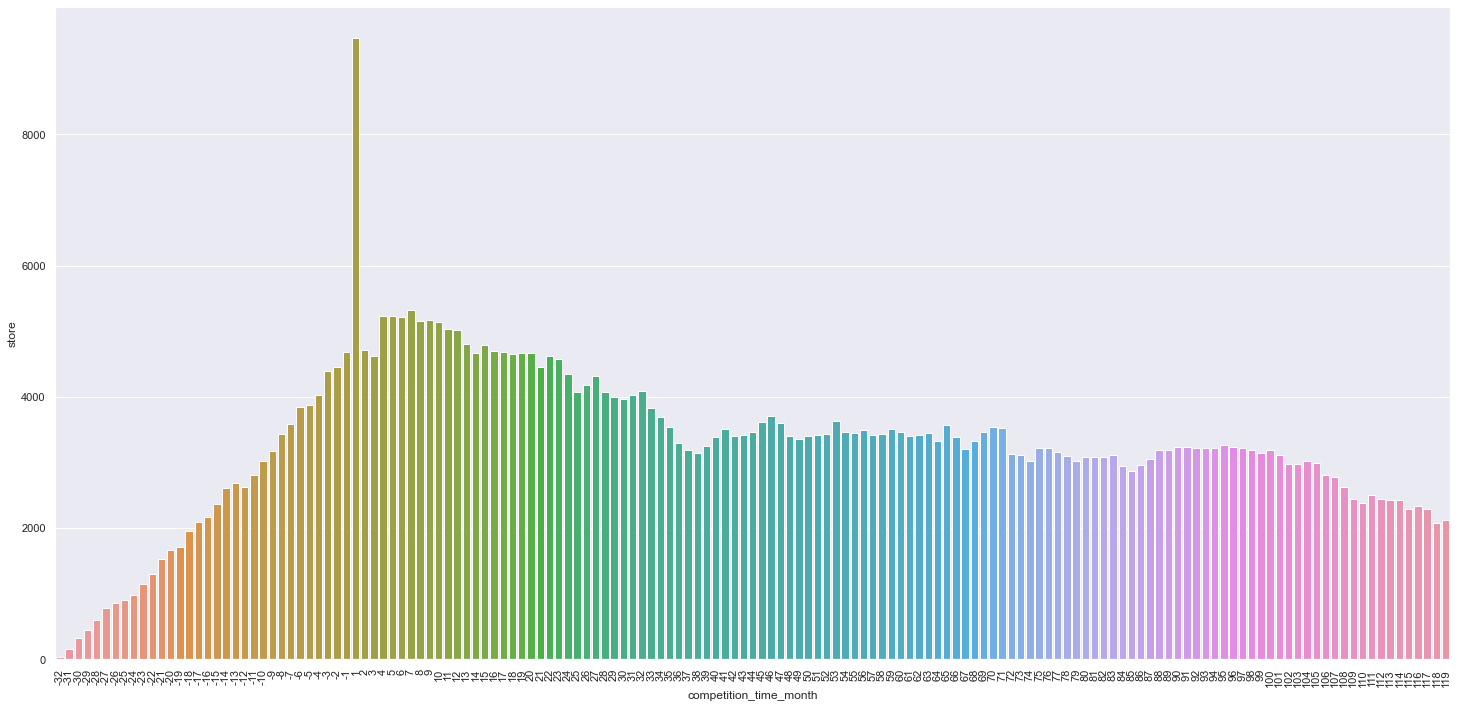

In [36]:
# Total de lojas por meses de competição
aux_count = df4[['competition_time_month', 'store']].groupby('competition_time_month').count().reset_index()
aux3 = aux_count[(aux_count['competition_time_month'] < 120) & (aux_count['competition_time_month'] != 0)] # 120 primeiros meses de competição e não competiram no mesmo mês da venda
sns.barplot(x='competition_time_month', y='store', data=aux3);
plt.xticks(rotation=90);

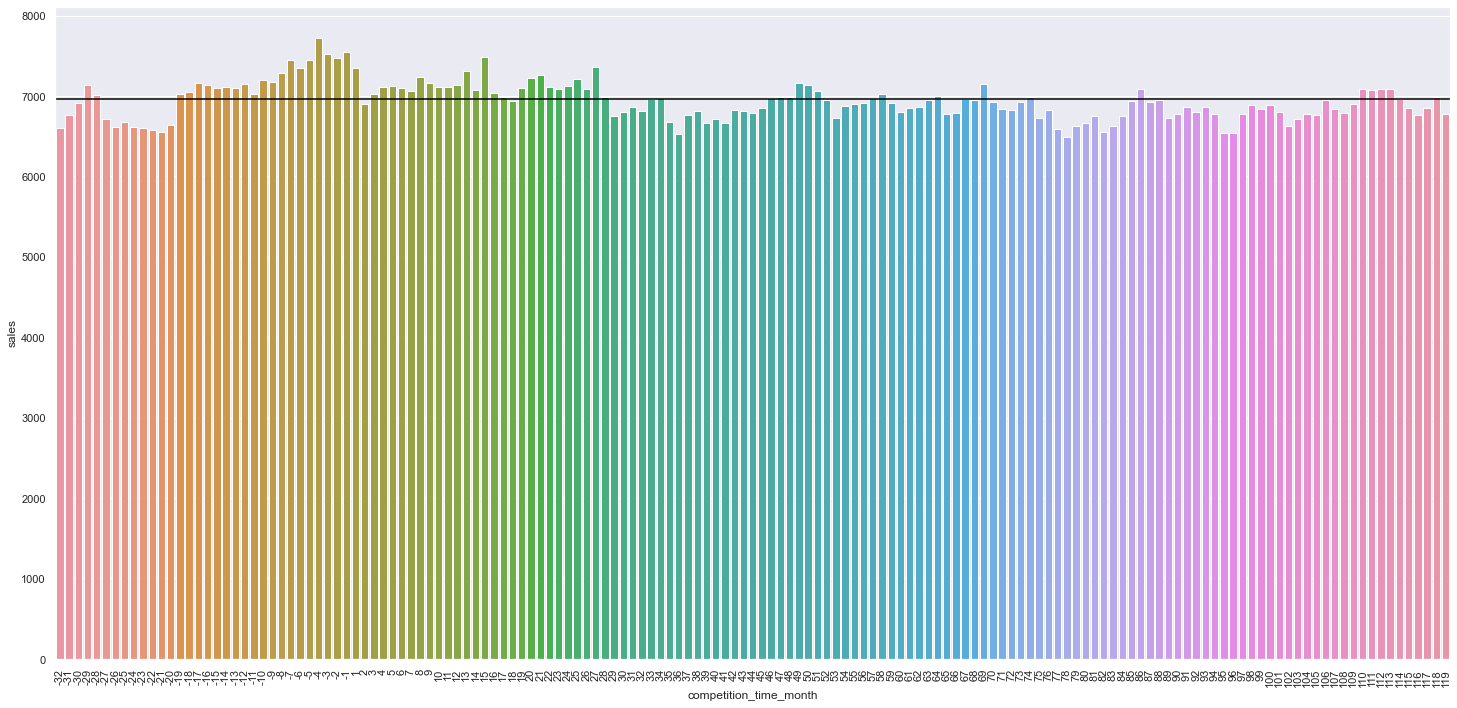

In [37]:
# Média de vendas de lojas por meses de competição
aux_mean = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux4 = aux_mean[(aux_mean['competition_time_month'] < 120) & (aux_mean['competition_time_month'] != 0)] # 120 primeiros meses de competição e não competiram no mesmo mês da venda
sns.barplot(x='competition_time_month', y='sales', data=aux4);
plt.axhline(6955.95, 0, 1, color='black')
plt.xticks(rotation=90);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**VERDADEIRO**: Lojas com promoções ativas por mais tempo vendem mais, depois de um certo período de promoção. Muitas lojas ficaram acima da média de vendas de 6955.

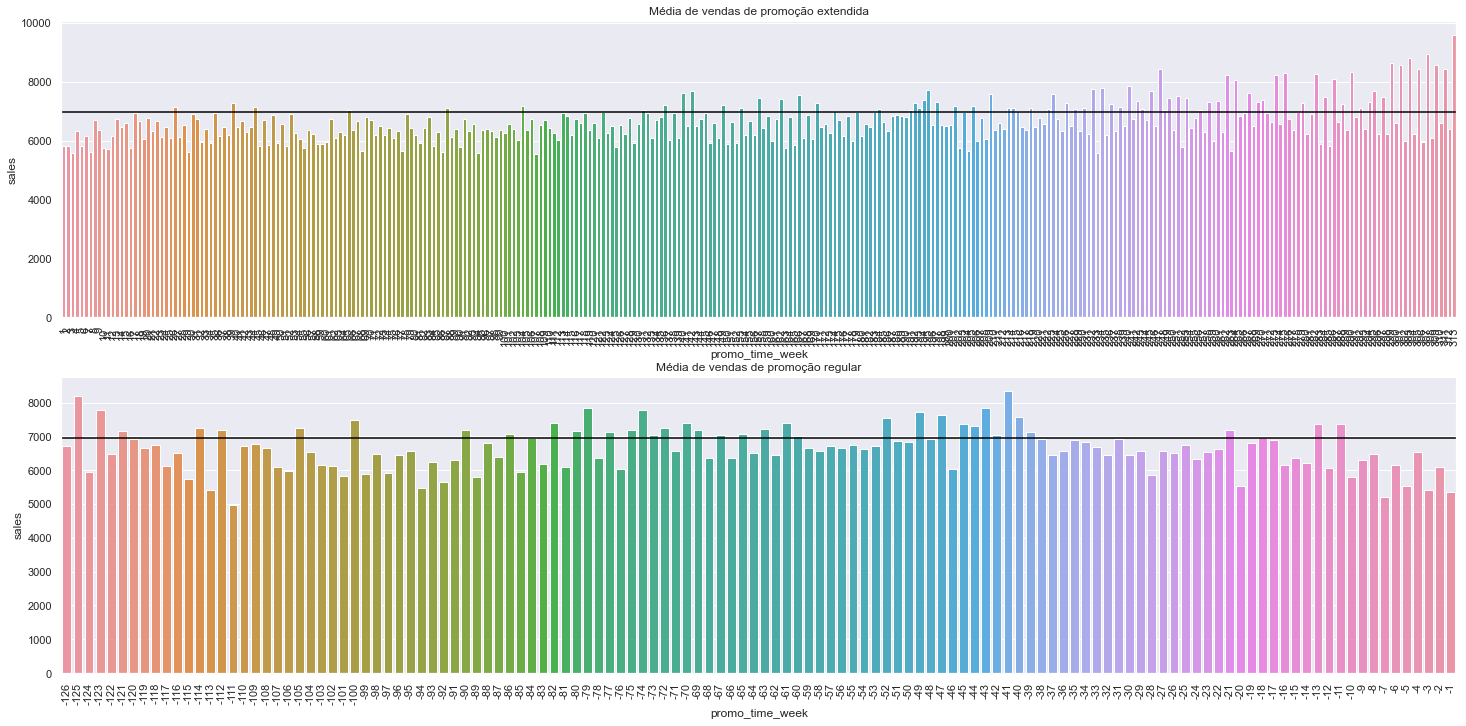

In [38]:
# Estratégia: pegar a média de vendas da promo_time_week, que indica:
# Valores negativos são referentes a vendas que aconteceram antes da promoção entrar em vigor.
# Valores positivos são referentes a vendas que aconteceram depois da promoção entrar em vigor.

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

# Gráfico de média de vendas de promoção extendida
plt.subplot(2,1,1)
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.title('Média de vendas de promoção extendida');
plt.axhline(6955.95, 0, 1, color='black')
plt.xticks(rotation=90);

# Gráfico de média de vendas de promoção regular
plt.subplot(2,1,2)
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.title('Média de vendas de promoção regular');
plt.axhline(6955.95, 0, 1, color='black')
plt.xticks(rotation=90);

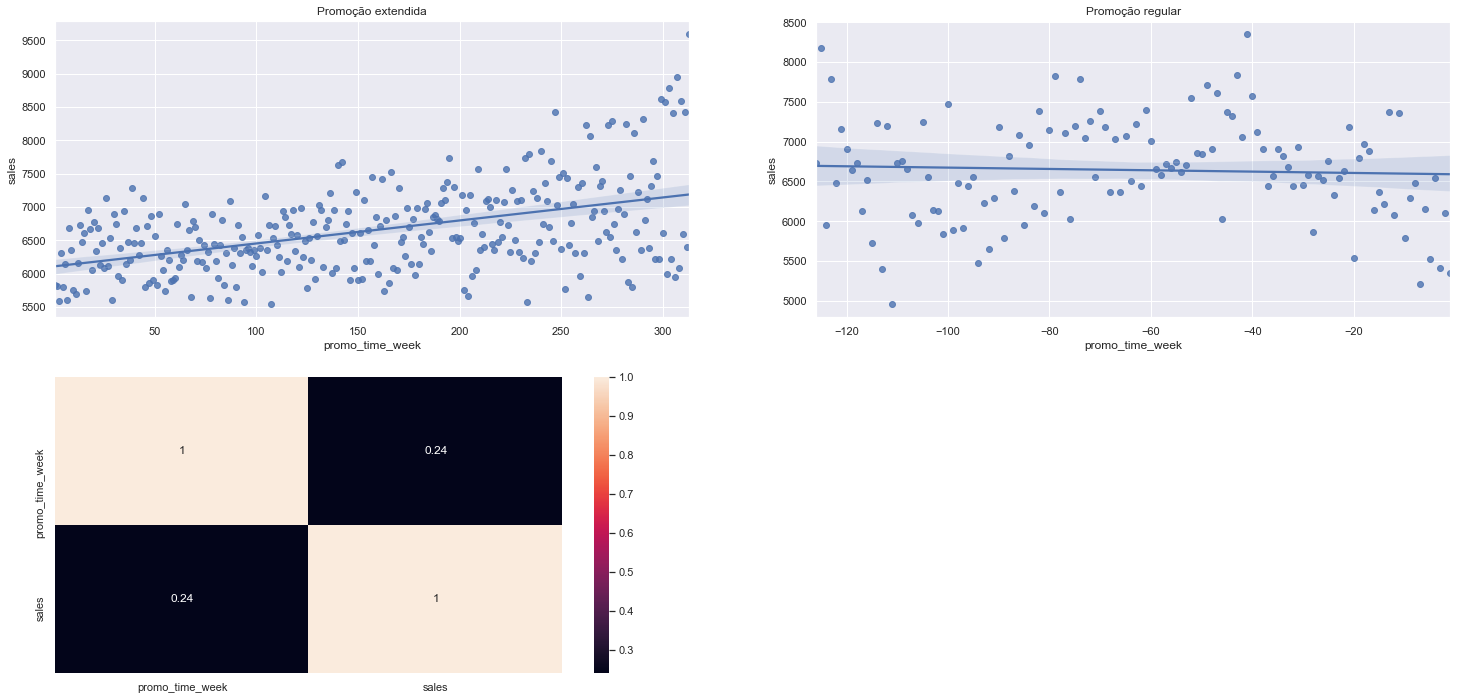

In [39]:
# Gráfico de dispersão
plt.subplot(2,2,1)
sns.regplot(x='promo_time_week', y='sales', data=aux2);
plt.title('Promoção extendida');

# Gráfico de dispersão
plt.subplot(2,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux3);
plt.title('Promoção regular');

# Gráfico que mede a força da correlação
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA**: Lojas com mais promoções consecutivas vendem menos do que lojas que participam apenas da promoção tradicional (1ª promoção).

In [40]:
# Estratégia: 
# Pegar a promo que indica que a loja está no período tradicional de promoções.
# Pegar a promo2 que indica que a loja está participando da promoção extendida.
# E pegar as médias de vendas.

df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().sort_values('sales', ascending=False).reset_index()

,promo,promo2,sales
0,1,0,8618.452062
1,1,1,7836.672987
2,0,0,6328.187633
3,0,1,5529.566684


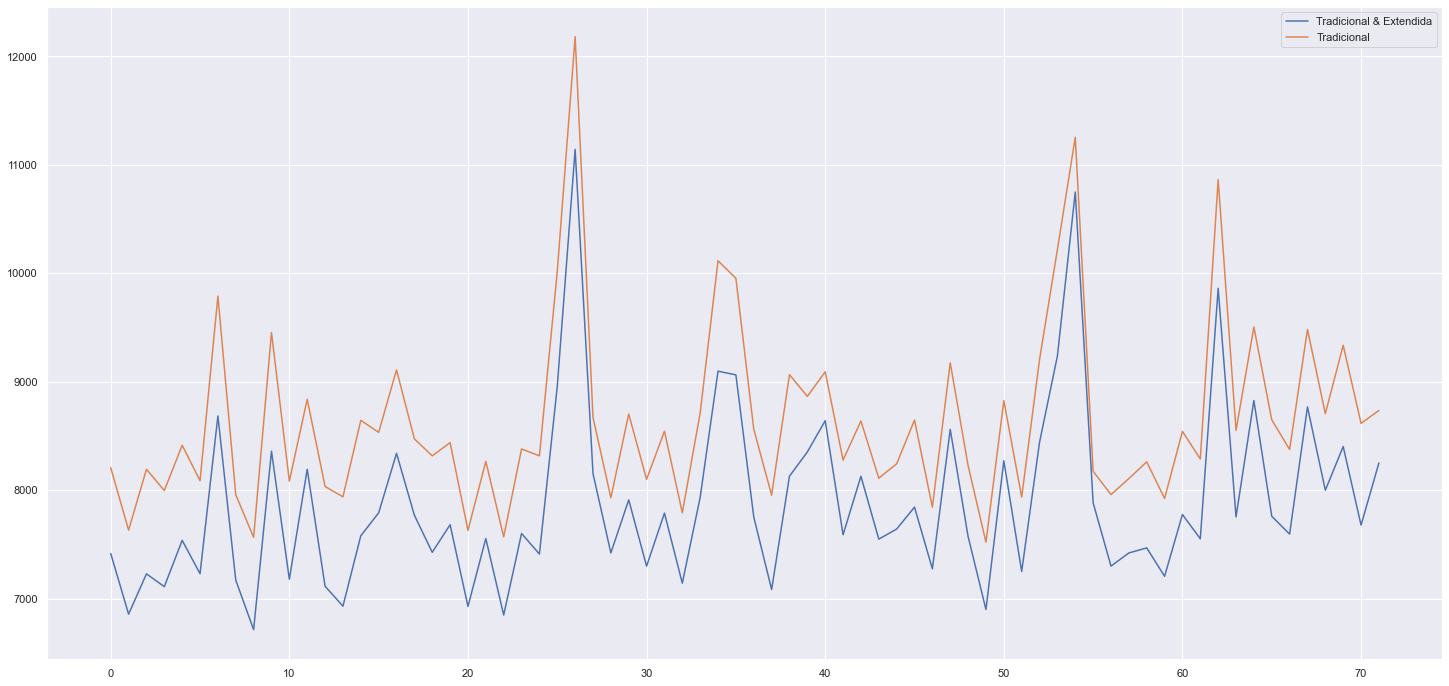

In [41]:
# Gráfico de média de vendas por promoção 'Tradicional & Extendida', 'Tradicional'.
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Tradicional']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA**: Lojas abertas durante o feriado de Natal na média vendem mais que os feriados públicos e dias normais, mas vedem menos que o feriado da Páscoa. Somente em 2014 que as lojas venderam mais no feriado de Natal.

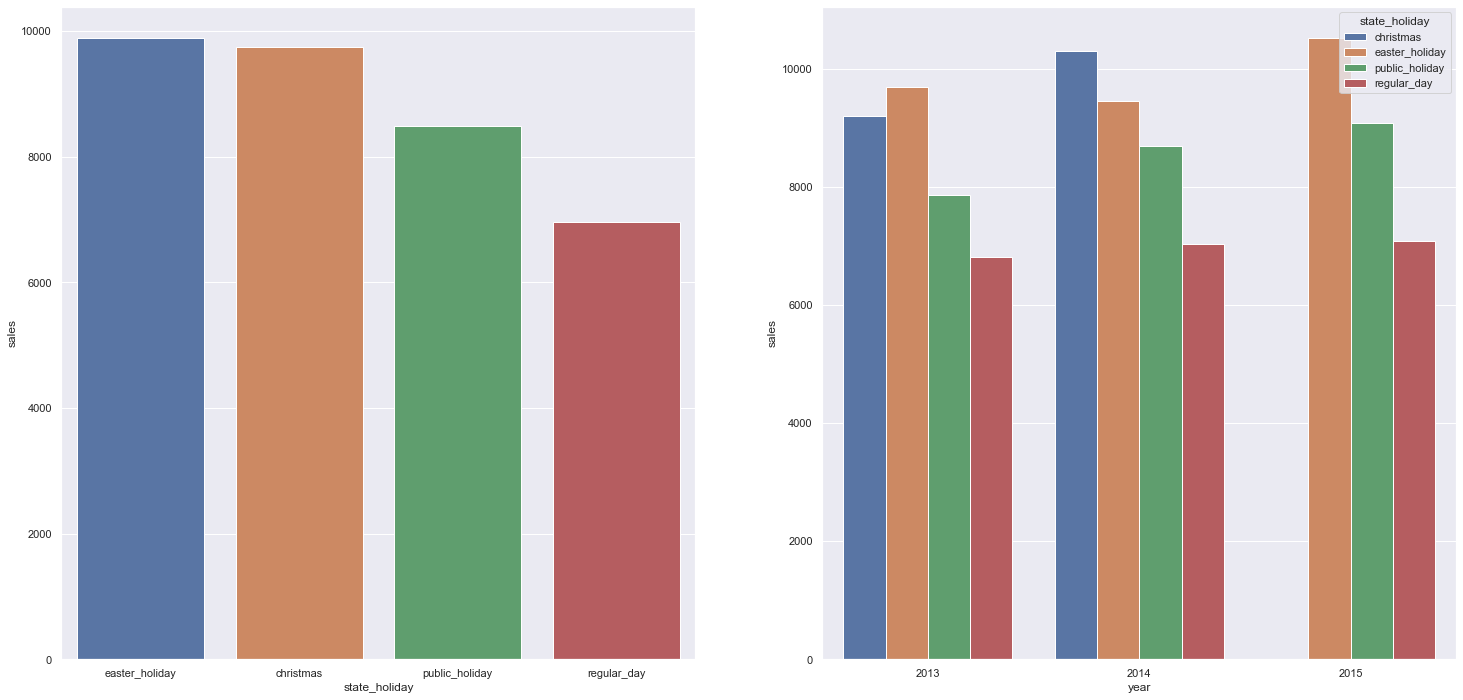

In [42]:
# Estrategia: pegar a média de vendas por state_holiday.
plt.subplot(1,2,1)
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().sort_values('sales', ascending=False).reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

# Grafico de média de vendas por state_holiday por anos.
plt.subplot(1,2,2)
aux2 = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA**: Lojas vendem menos ao longo dos anos.

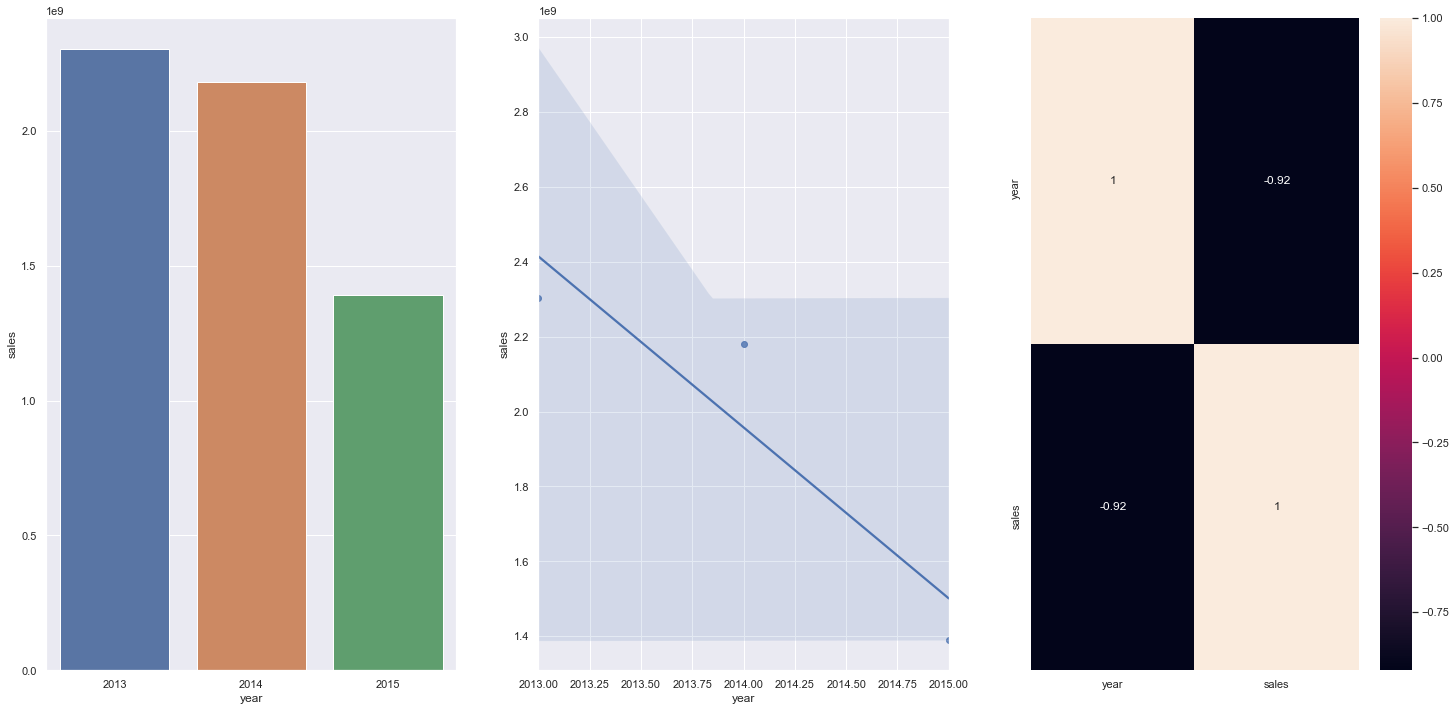

In [43]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# Gráfico de total de vendas por ano
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

# Tendência e força da correlação
plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# -0.92 de correlação = conforme os anos vão avançando as vendas vão caindo. 
# Isso é pelo fato do ano de 2015 não estar completo ainda. Quando os anos não estão completos ele puxa pra baixo a correlação

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA**: Lojas vendem menos no segundo semestre do ano.

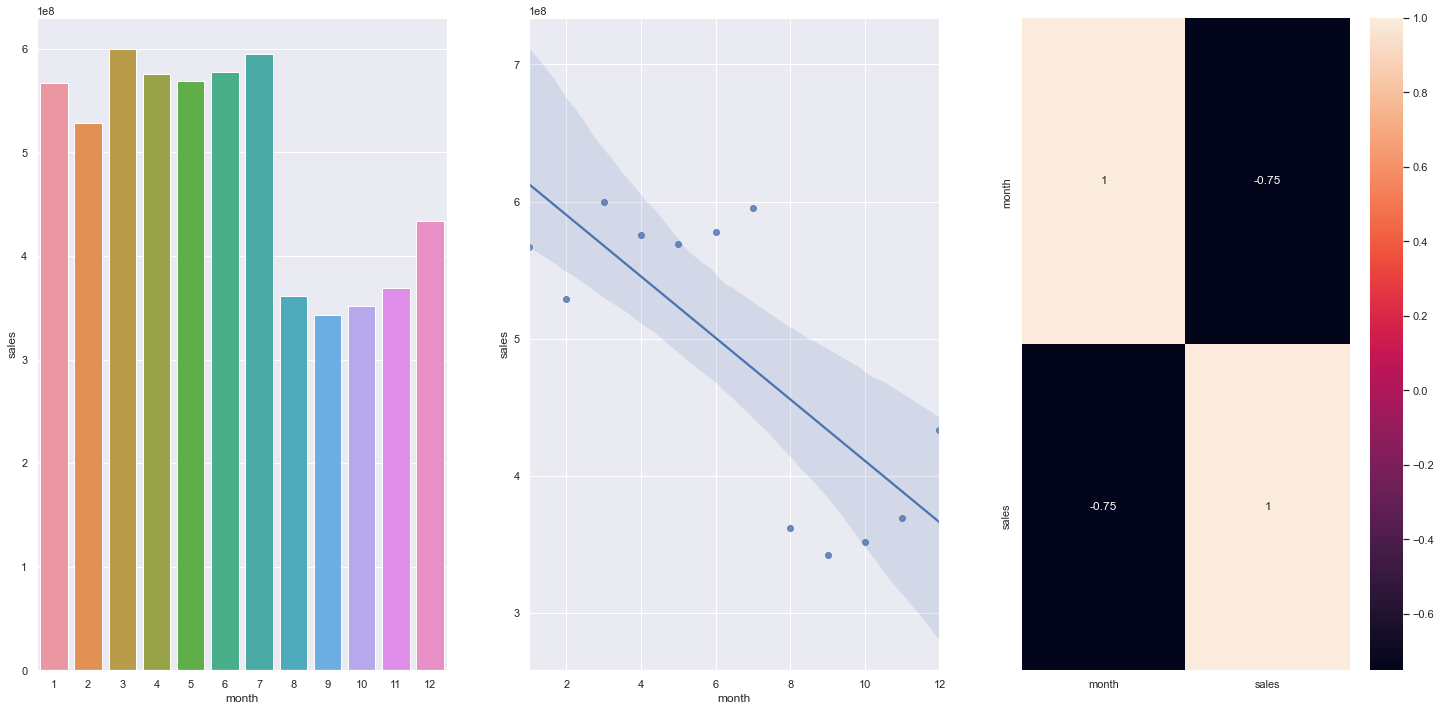

In [44]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# Gráfico de total de vendas por meses
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

# Tendência e força da correlação
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRO**: Lojas vendem mais depois do dia 10 de cada mes. Pelo fato de ter mais dias no mês, 20 dias contra 10.

As vendas são maiores antes do dia 10 quando olhamos para as médias de vendas pelos grupos: "Antes do dia 10" & "Depois do dia 10".

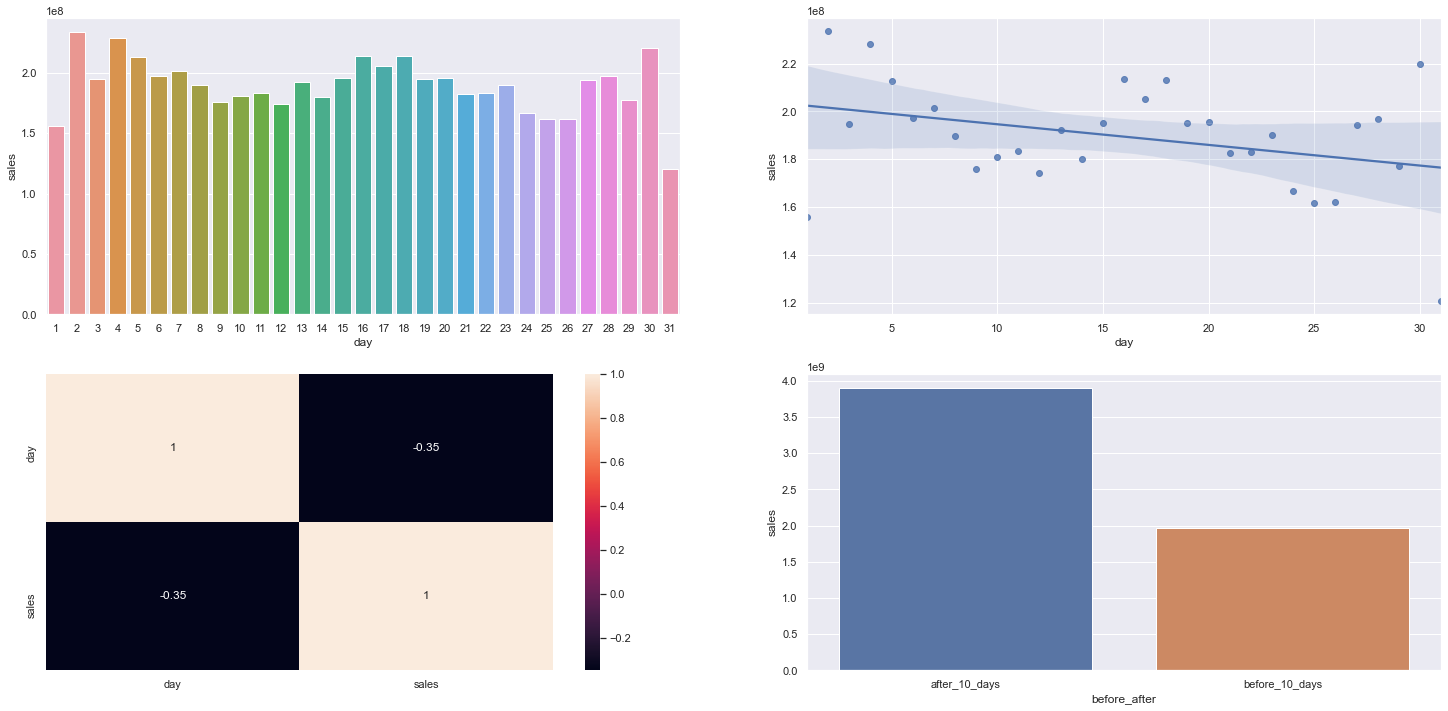

In [45]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

# Gráfico de vendas por dia
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

# Tendência e força da correlação
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 =aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

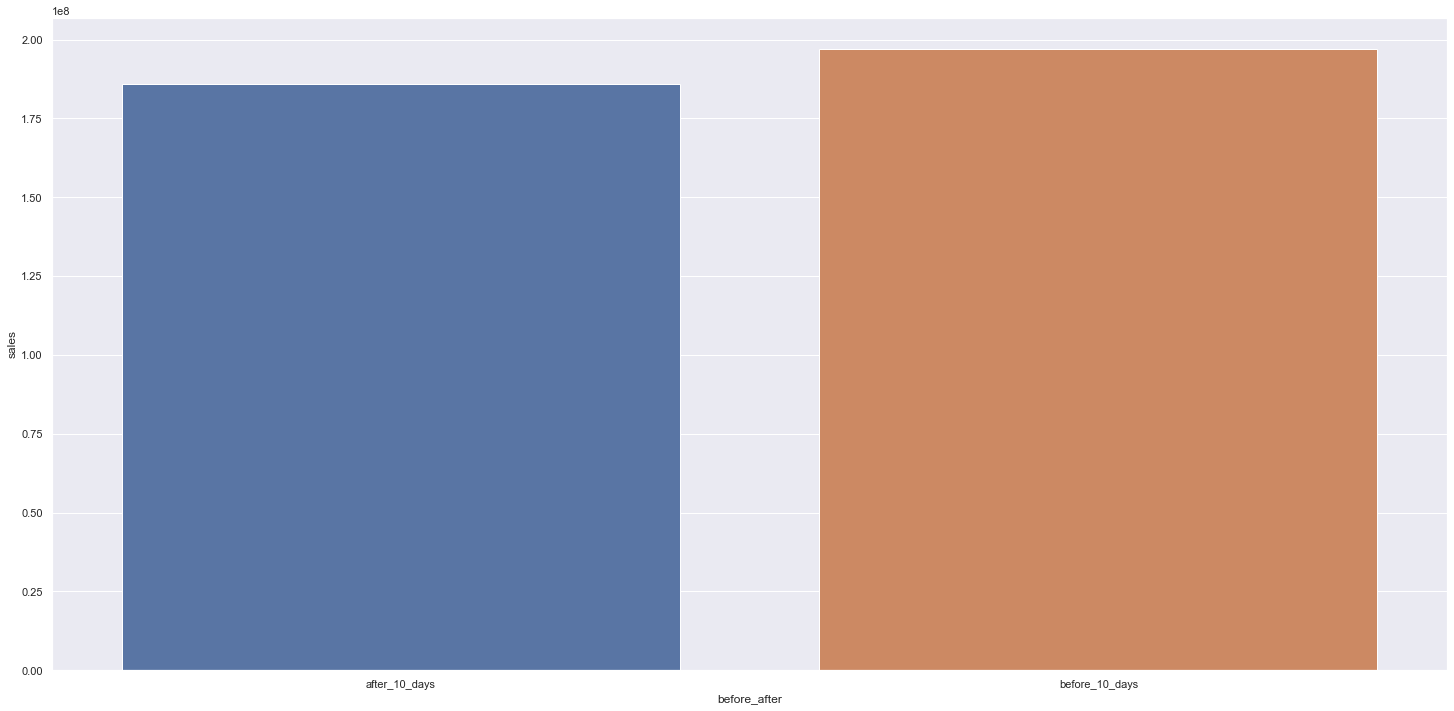

In [46]:
# Média de vendas por agrupados de dias: "Antes do dia 10" & "Depois do dia 10"
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux3 = aux1[['before_after', 'sales']].groupby('before_after').mean().reset_index()
sns.barplot(x='before_after', y='sales', data=aux3);

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**: Lojas vendem menos nos finais de semana.

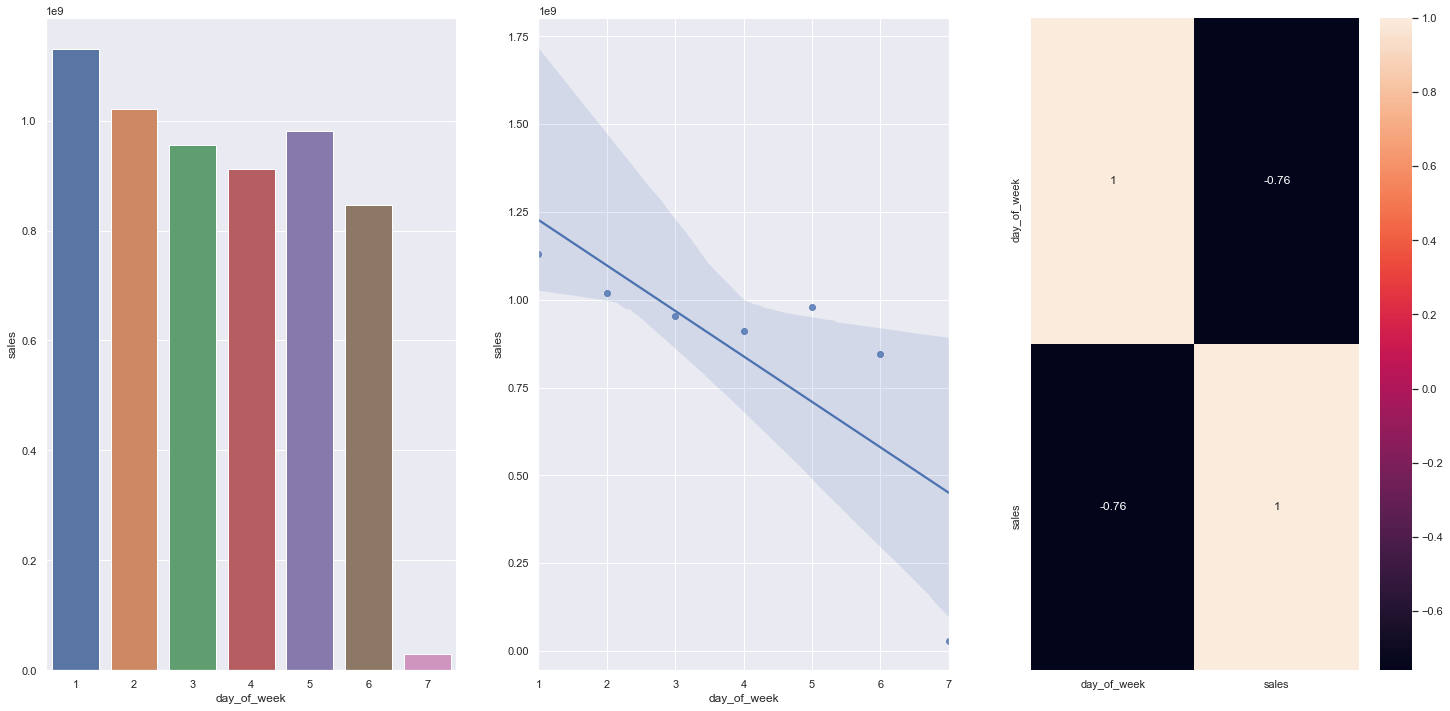

In [47]:
# Gráfico de vendas por dia da semana
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**FALSA**: Na média de vendas, os feriados escolares vendem mais do que os dias normais. Vendendo menos apenas no mês de Dezembro.

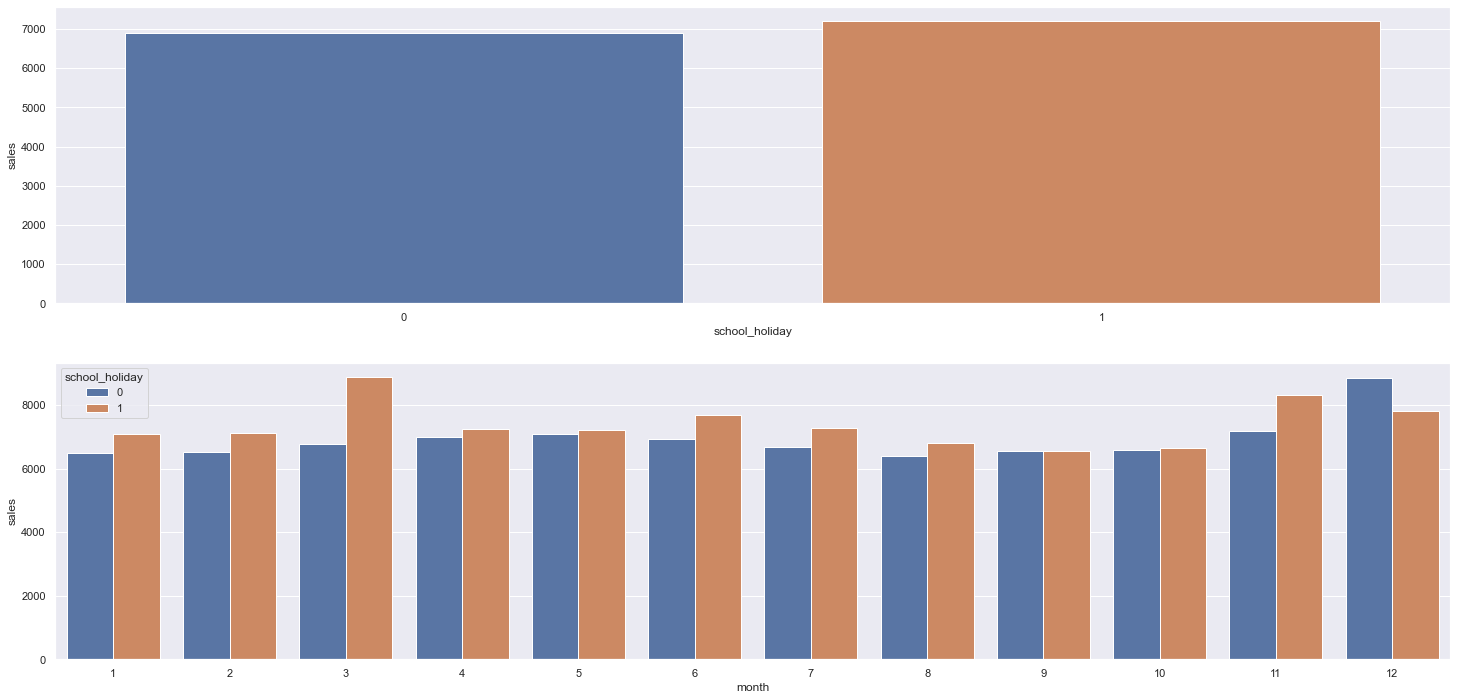

In [48]:
# Gráfico de média de vendas de feriado escolar e dias normais.
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

plt.subplot(2, 1, 1)
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).mean().reset_index()

plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Resumo das Hipóteses

In [49]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],

['H1', 'Verdadeira', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Verdadeiro', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Falsa', 'Alta'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Verdadeiro   Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Falsa        Alta


## 4.3. Análise Multivariada
Objetivo: Encontrar não só as correlações ou o impacto entre a variável e a variável resposta, mas as correlações entre as próprias variáveis.

### 4.3.1. Numerical Attributes

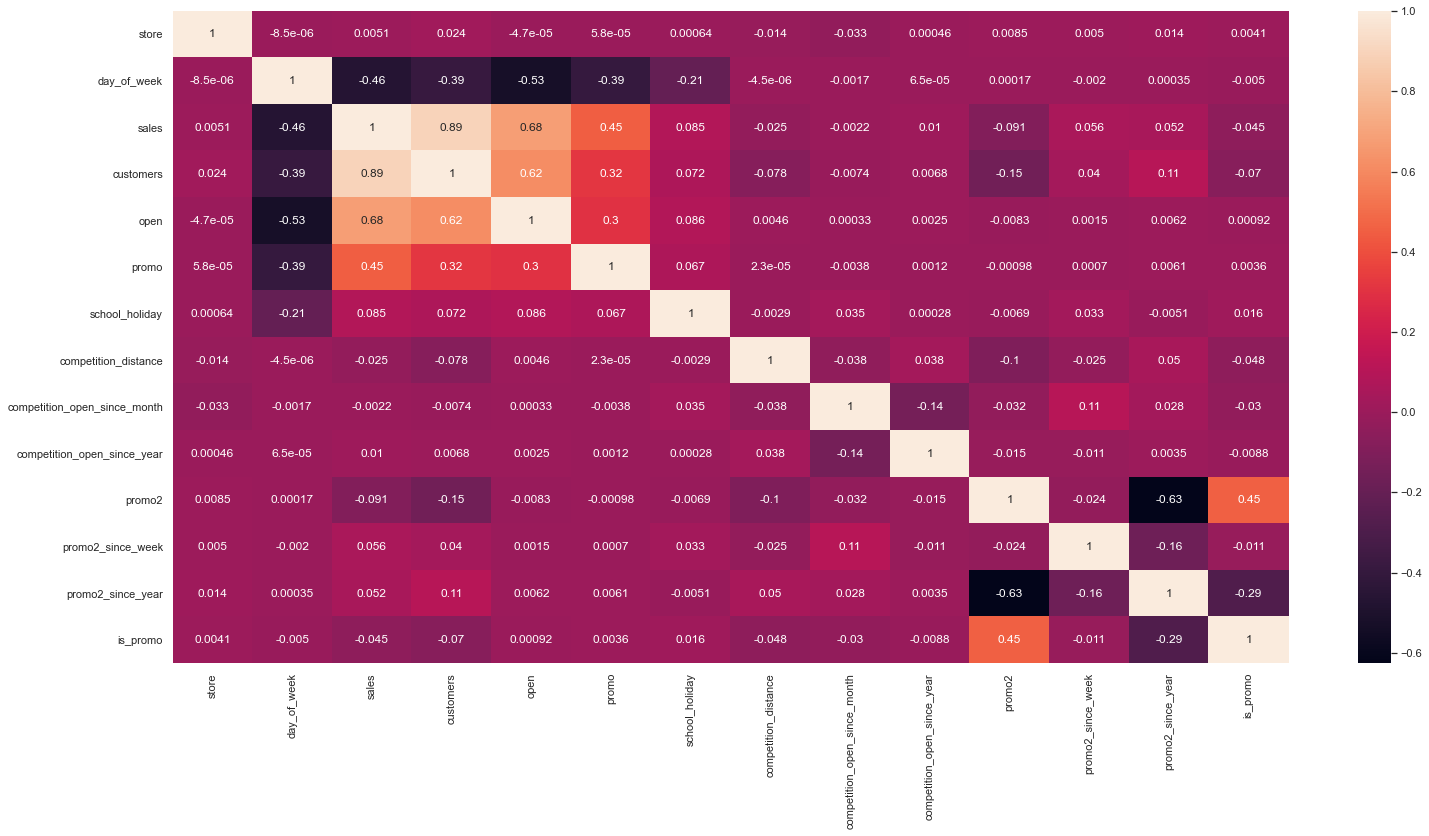

In [50]:
# Método corr = pearson: faz a correlação entre todas as variáveis númericas. Vai de -1 até 1.
# Gráfico de correlação: Quanto mais perto da cor preto, maior é a correlação negativa.
# Quanto mais perto da cor branca, maior é a correlação positiva.
# Devemos olhar os mais claros e mais escuros, o que tá no meio não é tão importante.
# A correlação entre duas variáveis que são a mesma é 1, porque estamos correlaciondo as mesmas variáveis. 

correlation = num_attributes.corr(method='pearson')
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

<AxesSubplot:>

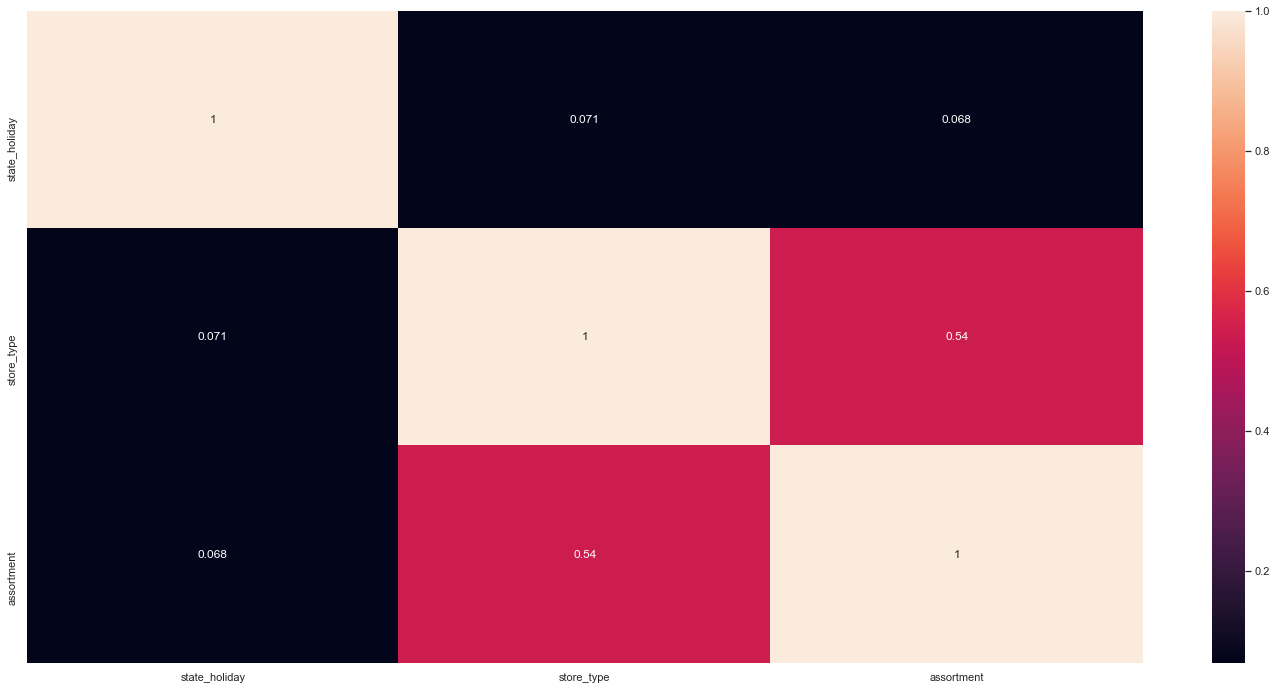

In [51]:
# Método Cramer V: para fazer a correlação entre todas as variáveis categóricas. Vai de 0 até 1, então não tem uma correlação negativa
# entre variáveis categóricas, é só uma correlação positiva ou nenhuma correlação. Quanto mais perto do 0 menor a correlação, 
# quanto mais perto do 1 maior a correlação.

# Matriz de confusão ou tabela de contingência: faz todas as possíveis combinações entre as variáveis categóricas e conta o número de 
# linhas daquelas combinações.

# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]
                 })

d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 5.0. PASSO 05 - PREPARAÇÃO DOS DADOS

Encoding:
- Trazer as variáveis categóricas para numéricas. Para que os algoritmos de Machine Learning consigam usar essas variáveis para aprender.

Normalização das escalas: 
- Mudar a escala, para que todo mundo fique no mesmo range.
- Rescala o centro para 0 com desvio-padrão igual a 1.
- Funciona muito bem para variáveis que possui uma distribuição normal
- Fórmula de Normalização: Pegar todos os valores da coluna de variável e calcular a média, depois calcular o desvio padrão. Depois pegar o primeiro valor da coluna, subtrair a média e dividir pelo desvio padrão, o resultado desse cálculo vai ser o novo valor. Então vamos trazer o valor antigo para uma nova escala que é o resultado dessa conta.

Rescaling: 
- Rescala para o intervalo entre 0 e 1.
- Distribuições não Gaussianas (não possui uma distribuição normal).
- Funciona muito bem para variáveis que NÃO possui uma distribuição normal
- Fórmula de Min-Max Scaler: Pegar a coluna de variável numérica onde vamos aplicar a fórmula, encontrar a média da coluna, encontrar o valor máximo e o valor mínimo da coluna, depois fazer a diferença entre o máximo e o mínimo (que é o range) e vai guardar esse valor, e ai pra cada valor original dessa variável, vamos subtrair a média e dividir pelo range. O resultado dessa conta vai se o novo valor em uma nova escala. E ai vamos gerar uma nova coluna com esses novos valores na nova escala. Essa fórmula é super sensível para outliers.
- Fórmula de Robust Scaler (tira a dependência do outilier): Pegar a coluna de variável numérica onde vamos aplicar a fórmula, encontrar a média da coluna, encontrar o valor do quartil 3 e o valor do quartil 1 da coluna, depois fazer a diferença entre o quartil 3 e o quartil 1 (que é o range) e vai guardar esse valor, e ai pra cada valor original dessa variável, vamos subtrair a média e dividir pelo range. O resultado dessa conta vai se o novo valor em uma nova escala. E ai vamos gerar uma nova coluna com esses novos valores na nova escala.

Transformação:
- Conversão de Features Categóricas para Numéricas (Encoding).
- Transformação de Natureza: Por exemplo, os meses é uma variável cíclica, pois dentro de cada ano tem o mesmo conjunto de meses, indo do 1 ao 12. Existe uma forma de transformar para cíclico para que o modelo entenda essa natureza cíclica.

In [52]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [53]:
# Selecionar somente as colunas com variáveis numéricas
a = df5.select_dtypes(include=['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


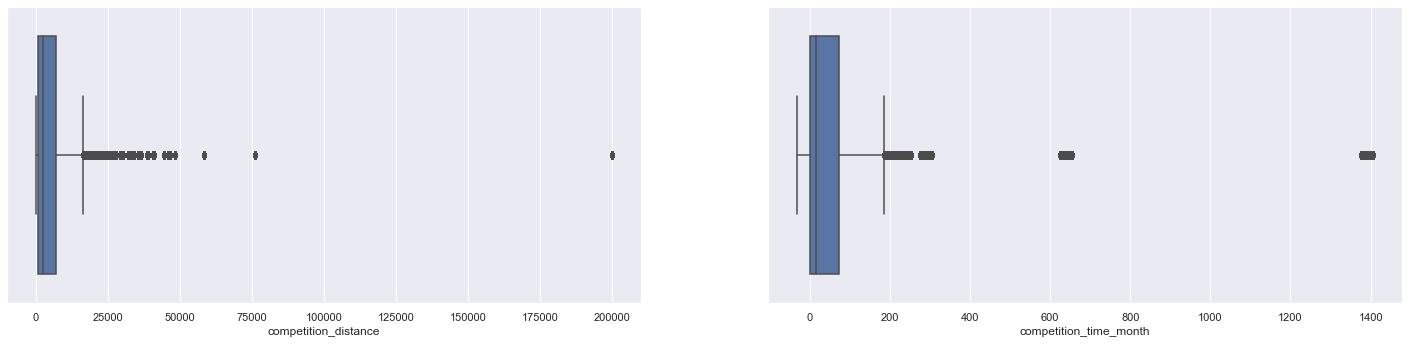

In [54]:
# Utilizar o boxplot para ver se tem outiliers
plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance']);

plt.subplot(2,2,2)
sns.boxplot(df5['competition_time_month']);

In [55]:
rs = RobustScaler()
mms = MinMaxScaler()

# RobustScaler
# competition distance
# metodo = fit_transform: encontra os parâmetros da fórmula e já aplica nos dados, os parâmetros da robust scaler são os quartis,
# quartil 1 e quartil 3. Então o fit_transform encontra o quartil 1 e quartil 3 da coluna e já aplica a fórmula.
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))


# MinMaxScaler
# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
#pickle.dump(rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values)
#pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.3. Tranformação

### 5.3.1. Encoding

In [56]:
# Separar as variáveis que tem natureza cíclica
# state_holiday - One Hot Encoding: get_dummies
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])
#pickle.dump( le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [57]:
# Logarithm Transformation: Tranformar a variável resposta, usar o logarítmo log1p na variável sales
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [58]:
# Pegar a variável (day of week, month...), transformar em duas variáveis seno e cosseno que combinadas vão representar a natureza cíclica

# day of week
# pi dividido pelo tamanho do ciclo, no caso de dias de semana, são 7
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
# pi dividido pelo tamanho do ciclo, no caso de meses, são 12
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12))) 
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
# pi dividido pelo tamanho do ciclo, no caso de dias, são 30
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30))) 
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
# pi dividido pelo tamanho do ciclo, no caso de semanas, são 52
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52))) 
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0. PASSO 06 - FEATURE SELECTION

In [59]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [61]:
# Excluir as colunas originais, pois derivamos novas variáveis na Feature Engineering. Exemplo a week_of_year sin e cos.
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [69]:
# Pegar a data mínima de vendas e máxima de vendas
#df6[['store', 'date']].groupby('store').max().reset_index()

# Pegar a data de 6 semanas antes do max date acima 
#df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

In [70]:
# training dataset: pegar dados anteriores a data 19-06-2015
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset: pegar dados posteriores ou igual a data 19-06-2015
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector
Iteration: 	9 / 100 = Número da Iteração.

Confirmed: 	18 = Quantas variáveis o boruta já confirmou como sendo relevantes para o modelo.

Tentative: 	0 = São variáveis que o boruta teve dúvida, ele não conseguiu nessa iteração classificá-las como sendo irrelevantes ou não.

Rejected: 	9 = São variáveis que o boruta já rejeitou e considerou como não sendo relevantes para o modelo.

In [71]:
# # training and test dataset for Boruta
# # dropar as colunas date e sales pois é o conjunto de treino
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# # ravel = coloca tudo dentro de um vetor
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# # n_jobs=-1 = usa todos os cores da máquina e faz o processamento paralelo, criando as árvores em paralelo
# rf = RandomForestRegressor(n_jobs=-1)

# # define Boruta
# # rf = random forest, n_estimator = auto = o modelo define o melhor número de ramificações, verbose = 2 = para ver os prints do algoritmo, 
# # random_state = 42 = toda vez que ele selecionar uma variável aleatória, cravamos o início dele em 42 e parta do mesmo ínicio
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Best Features from Boruta

In [72]:
cols_selected = boruta.support_.tolist()

# best features: o boruta rankeia as colunas como sendo relevantes
# Como não podemos mais usar o X_train_n porque ele virou um vetor, criamos a X_train_fs com a X_train dropando date e sales
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta: ver as colunas que o boruta não selecionou, vamos ver o que tem na X_train_fs que não tem nas que ele selecinou 
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

In [73]:
# Colunas relevantes para o modelo
#cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [74]:
# Colunas não relevantes para o modelo
#cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3. Manual Feature Selection

In [76]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING
3 tipos de erros:
- MAE: 
    
- MAPE: 
    
- RMSE: 

In [79]:
# Selecionar as colunas mais relevantes segundo o boruta
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
#x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model (Modelo de Média)
O principal papel do modelo de média é ser uma base comparativa para a perfomance dos outros modelos.

In [85]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy() # criar variável sales no aux1 e copiar essa variável para y_test

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store') # join com o conjunto original
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) # expm1 = exponencial para voltar o log no valor original
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model (Modelo de Regressão Linear)
Usamos algoritmos lineares, que são algoritmos mais simples, se o modelos lineares eles tiverem uma boa performance, podemos assumir que o conjunto de dados tem um comportamento linear. Agora se os modelos lineares tiverem uma performance muito ruim, significa que o conjunto de dados ou o fenômeno que estamos tentando modelar é complexo, então precisamos de algoritmos não lineares como redes neurais, random forest e SVN.

In [86]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr)) # expm1 = exponencial para voltar o log no valor original
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [87]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr,verbose=False)
lr_result_cv

NameError: name 'cross_validation' is not defined

## 7.3. Linear Regression Regularized Model (Modelo de Regressão Linear Regularizada) - Lasso
Tem um parâmetro a mais, também chamado de Lasso ou Ridge e geralmente ele performa um pouco melhor que a Regressão Linear.

In [88]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train) # alpha = fator multiplicativo de cada um dos pesos para que eles fiquem dentro de um range 
                                                #e assim tenham a mesma relevância ou sejam comparáveis entre todas as variáveis
                                                #diminuindo o valor de alpha pode melhorar o valor de RMSE

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr)) # expm1 = exponencial para voltar o log no valor original
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

## 7.4. Random Forest Regressor
Modelos baseado em ávores que foram adaptados para regressões.

In [ ]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

### 7.4.1. Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

## 7.5. XGBoost Regressor
Modelos baseado em ávores que foram adaptados para regressões. A diferença é que usa um método beggin e boost para poder selecionar as features mais rápido e mais relevantes, tem uma performance melhor.

In [ ]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',

n_estimators=100,
eta=0.01,
max_depth=10,
subsample=0.7,
colsample_bytee=0.9 ).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

### 7.5.1. XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

## 7.6. Compare Model’s Performance

### 7.6.1. Single Performance

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

### 7.6.2. Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv